# PUI Final 2016
## Laura Gladson, netid: lag552

### GOAL: Identify NYC neighborhoods that are homogeneous by clustering their socioeconomic characteristics in 2000, and in 2010, and find the neighborhoods that change cluster, indicating that they evolve differently with respect to their cluster peers (e.g. gentrification).

## Importing Packages

In [1]:
import pandas as pd
import json
import os
import pylab as pl
import geopandas as gp
import glob
import zipfile
from sklearn.cluster import KMeans
from matplotlib import cm
from descartes import PolygonPatch
import scipy.cluster as scp
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
from pandas.io.common import ZipFile
import pylab as pl
import zipfile
from geopandas import GeoDataFrame
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans2
import scipy.stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Steps 1 & 2: Find the number of businesses in 2010 and 2000. Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile.

In [ ]:
# Getting the business data for 2000 and 2010

!wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
    
!wget ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip

In [ ]:
!unzip zbp00totals.zip

In [ ]:
os.system("mv zbp00totals.txt " + os.getenv("PUIDATA"))

In [ ]:
!unzip zbp10totals.zip

In [ ]:
os.system("mv zbp10totals.txt " + os.getenv("PUIDATA"))

In [2]:
# Loading dataframe for 2000 business data by zip code (entire U.S., will be reduced to NYC later)
bus00 = pd.read_csv(os.getenv('PUIDATA') + '/' + 'zbp00totals.txt')
bus00.head()

ZIP            NAME EMPFLAG   EMP    QP1      AP  EST
0   501  HOLTSVILLE, NY       A     0      0       0    1
1  1001      AGAWAM, MA     NaN  8042  59833  259661  493
2  1002     AMHERST, MA     NaN  6547  36719  169658  563
3  1003     AMHERST, MA     NaN    82    308    2482   13
4  1004     AMHERST, MA     NaN   717   2049    5826   48

In [3]:
# Removing unneeded columns
bus00 = bus00[['ZIP', 'EST']]
bus00.head()

ZIP  EST
0   501    1
1  1001  493
2  1002  563
3  1003   13
4  1004   48

In [4]:
# Loading dataframe for 2010 business data by zip code (entire U.S., will be reduced to NYC later)
bus10 = pd.read_csv(os.getenv('PUIDATA') + '/' + 'zbp10totals.txt')
bus10.head()

zip            name empflag emp_nf    emp qp1_nf    qp1 ap_nf      ap  \
0   501  HOLTSVILLE, NY       A      D      0      D      0     D       0   
1  1001      AGAWAM, MA     NaN      G   9185      G  70693     G  314508   
2  1002     AMHERST, MA     NaN      G  15633      G  82069     G  351589   
3  1003     AMHERST, MA     NaN      G    168      H   1297     H    5761   
4  1004     AMHERST, MA     NaN      H    189      H   1710     H    7241   

   est        city stabbr   cty_name  
0    2  HOLTSVILLE     NY    SUFFOLK  
1  448      AGAWAM     MA    HAMPDEN  
2  570     AMHERST     MA  HAMPSHIRE  
3   16     AMHERST     MA  HAMPSHIRE  
4   21     AMHERST     MA  HAMPSHIRE

In [5]:
# Removing unneeded columns
bus10.rename(columns = {"zip": "ZIP", "est": "EST"}, inplace = True)
bus10 = bus10[['ZIP', 'EST']]
bus10.head()

ZIP  EST
0   501    2
1  1001  448
2  1002  570
3  1003   16
4  1004   21

### The above tables provide the number of businesses (est, for establishments) by zip code for the entire U.S. This will be reduced to NYC further on.

In [ ]:
# Loading NYC zip code geographies file
!curl -O https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson

In [ ]:
os.system("mv nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA"))

In [8]:
zip_file = os.getenv('PUIDATA') + '/nyc-zip-code-tabulation-areas-polygons.geojson'
zip_file

'/home/cusp/lag552/PUIdata/nyc-zip-code-tabulation-areas-polygons.geojson'

In [9]:
zip_shape = gp.read_file(zip_file)

In [10]:
# Loading zip code shapefile for NYC
zip_shape = zip_shape[pd.notnull(zip_shape['postalCode'])]
zip_shape = zip_shape[['Shape_Area', 'borough', 'geometry', 'postalCode']]
zip_shape.rename(columns = {"postalCode": "ZIP"}, inplace = True)
zip_shape.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  
0  11372  
1  11004  
2  11040  
3  11426  
4  11365

In [11]:
zip_shape.dtypes

Shape_Area    float64
borough        object
geometry       object
ZIP            object
dtype: object

In [12]:
zip_shape['ZIP'] = pd.to_numeric(zip_shape['ZIP'])
zip_shape['ZIP'].head()

0    11372
1    11004
2    11040
3    11426
4    11365
Name: ZIP, dtype: int64

In [402]:
# Merging Zip Code Shapefile with Business Data

# First adding 2000 business data to shapefile
business = pd.merge(zip_shape, bus00, how='inner', on=['ZIP'])

# Then adding 2010 business data to shapefile
business = pd.merge(business, bus10, how='inner', on=['ZIP'])

business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  EST_x  EST_y  
0  11372   1409   1629  
1  11004    189    229  
2  11040   1350   1494  
3  11426    213    248  
4  11365    553    643

In [403]:
# Finding area of each zip code's polygon geometry
# Chose this method instead of using provided Shape_Area values, since those returned poor map results further on
business['zip_area'] = business.geometry.area.sum()
business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  EST_x  EST_y  zip_area  
0  11372   1409   1629   0.08228  
1  11004    189    229   0.08228  
2  11040   1350   1494   0.08228  
3  11426    213    248   0.08228  
4  11365    553    643   0.08228

In [412]:
business.rename(columns = {"EST_x" : "EST00", "EST_y" : "EST10"}, inplace = True)
print('Business Data Merged with Zip Code Shapefile')
business.head()

Business Data Merged with Zip Code Shapefile


Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  EST00  EST10  zip_area        Dens00        Dens10     DensDiff  
0  11372   1409   1629   0.08228  17124.465233  19798.263921  2673.798688  
1  11004    189    229   0.08228   2297.036146   2783.181362   486.145216  
2  11040   1350   1494   0.08228  16407.401040  18157.523817  1750.122778  
3  11426    213    248   0.08228   2588.723275   3014.100339   425.377064  
4  11365    553    643   0.08228   6720.957611   7814.784347  1093.826736

In [406]:
print('There are', len(business), 'zip codes in NYC with business data available in 2000 and 2010 for analysis.')

There are 250 zip codes in NYC with business data available in 2000 and 2010 for analysis.


In [407]:
est_2000 = business.EST00.sum(axis = 0)
print("There were", est_2000, 'businesses in NYC in 2000.')

There were 210230 businesses in NYC in 2000.


In [408]:
est_2010 = business.EST10.sum(axis = 0)
print("There were", est_2010, 'businesses in NYC in 2010.')

There were 227820 businesses in NYC in 2010.


In [409]:
print('There was a cumulative increase of', (est_2010 - est_2000), 'businesses from 2000 to 2010.')

There was a cumulative increase of 17590 businesses from 2000 to 2010.


## Step 3: Find the density of businesses by dividing the number of businesses by the area of the zipcode and show them the density in a choropleth for 2000 and 2010. OPTIONALLY: also show the difference in business density between 2000 and 2010 in a map. 

In [410]:
# Adding business density columns by dividing # of businesses per zip code by its area
# SOURCE: https://catalog.data.gov/dataset/zip-code-boundaries

business['Dens00'] = business['EST00'] / business['zip_area']
business['Dens10'] = business['EST10'] / business['zip_area']
business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  EST00  EST10  zip_area        Dens00        Dens10  
0  11372   1409   1629   0.08228  17124.465233  19798.263921  
1  11004    189    229   0.08228   2297.036146   2783.181362  
2  11040   1350   1494   0.08228  16407.401040  18157.523817  
3  11426    213    248   0.08228   2588.723275   3014.100339  
4  11365    553    643   0.08228   6720.957611   7814.784347

In [411]:
# Adding a column for the difference in business density
business['DensDiff'] = business['Dens10'] - business['Dens00']
business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  EST00  EST10  zip_area        Dens00        Dens10     DensDiff  
0  11372   1409   1629   0.08228  17124.465233  19798.263921  2673.798688  
1  11004    189    229   0.08228   2297.036146   2783.181362   486.145216  
2  11040   1350   1494   0.08228  16407.401040  18157.523817  1750.122778  
3  11426    213    248   0.08228   2588.723275   3014.100339   425.377064  
4  11365    553    643   0.08228   6720.957611   7814.784347  1093.826736

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


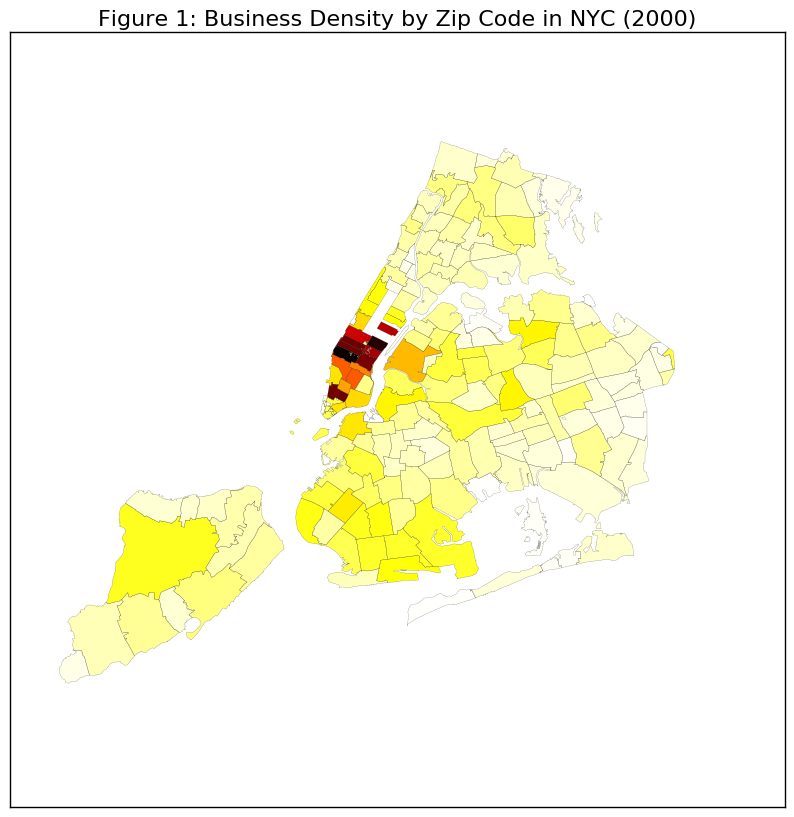

In [19]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
business.plot(column = 'Dens00', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 1: Business Density by Zip Code in NYC (2000)", fontsize = 16)

## Figure 1 Caption:
### The above map shows the density of businesses in each zip code in NYC in 2000. Darker colors represent higher densities in that zip code. Midtown Manhattan shows the highest densities compared to the rest of the city.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


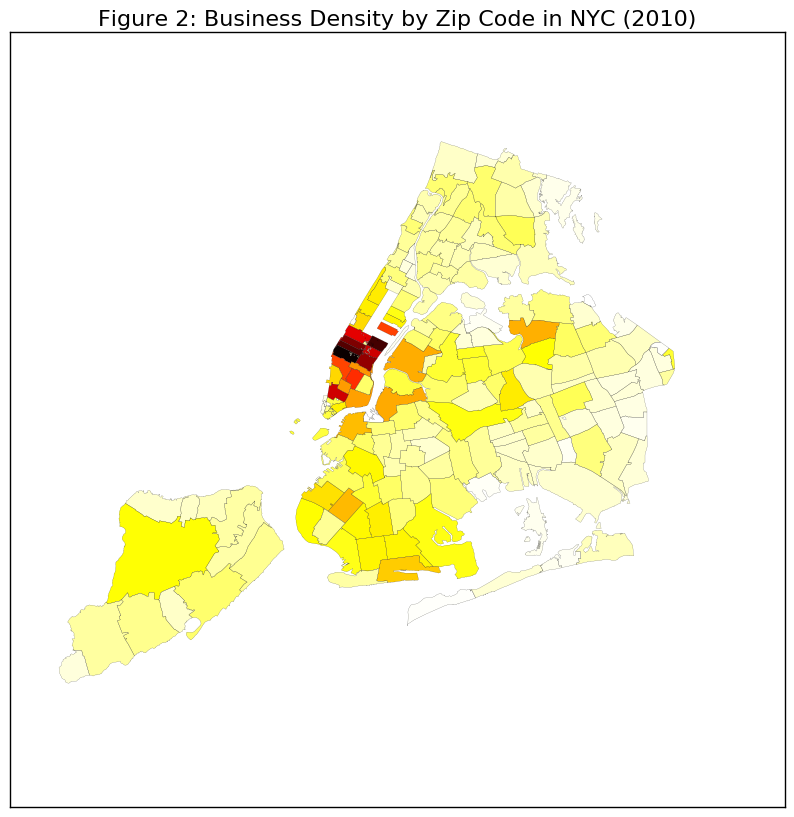

In [20]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
business.plot(column = 'Dens10', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 2: Business Density by Zip Code in NYC (2010)", fontsize = 16)

## Figure 2 Caption:
### The above map shows the density of businesses in each zip code in NYC in 2010. Darker colors represent higher densities in that zip code. Like in 2000, Midtown Manhattan shows the highest densities compared to the rest of the city, though it appears a few zip codes in Queens and Brooklyn increased business density slightly compared to the previous map of 2000.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


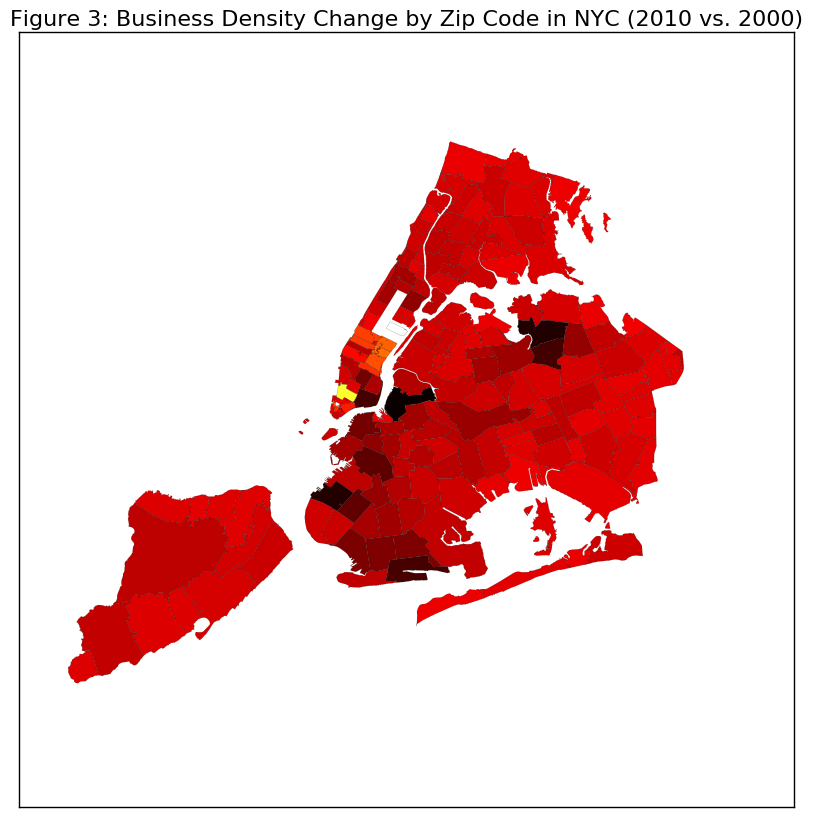

In [21]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
business.plot(column = 'DensDiff', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 3: Business Density Change by Zip Code in NYC (2010 vs. 2000)", fontsize = 16)

## Figure 3 Caption:
### The above map shows the difference in density of businesses in each zip code in NYC from 2000 to 2010. This value was obtained by subtracting the densities of 2000 from 2010. Darker colors represent higher differences in densities in that zip code between the two years. Here, one can confirm the observation from Figure 2, that a few zip codes in Queens and Brooklyn (the darkest patches) did increase in business density from 2000 to 2010. It is also clear by the lighter patches in Midtown Manhattan that business densities grew the least here in comparison to the other zip codes and boroughs. One might suggest this is because real estate in Midtown Manhattan is so scarce that there was little room for more businesses to be established. 

## Step 4: Collect census data from the 2010 and 2000 census and extract the estimate (mean) age, population, and diversity of each census tract for all 5 NYC boroughs. The diversity (or lack thereof) can be measured by the fraction of white population.

In [ ]:
# Loading demographic data by census tract for 2010
!wget http://www2.census.gov/geo/tiger/TIGER2010DP1/Tract_2010Census_DP1.zip

In [ ]:
!unzip Tract_2010Census_DP1.zip

In [ ]:
os.system("mv Tract_2010Census_DP1.shp " + os.getenv("PUIDATA"))

In [23]:
ct10_shape = GeoDataFrame.from_file(os.getenv('PUIDATA') + '/' + 'Tract_2010Census_DP1.shp')
ct10_shape.head()

ALAND10   AWATER10  DP0010001  DP0010002  DP0010003  DP0010004  \
0  352811329.0   499970.0       1638         98         87         88   
1   16201446.0  8339342.0       4583        456        387        363   
2   14630162.0   380622.0       2055        110        137        128   
3  127200997.0   112809.0       1727        101        112        106   
4  101697268.0  1101261.0       2099        137        160        166   

   DP0010005  DP0010006  DP0010007  DP0010008  \
0        115         76         96         78   
1        348        326        313        230   
2        150        108        112        104   
3        120         88        103         78   
4        149        129        122        123   

                         ...                          DP0220002  DP0230001  \
0                        ...                                355       2.36   
1                        ...                               2387       2.56   
2                        ...                                798       2.29   
3                        ...                                663       2.46   
4                        ...                                804       2.54   

   DP0230002      GEOID10   INTPTLAT10    INTPTLON10         NAMELSAD10  \
0       2.75  01005950300  +31.7908933  -085.5670514  Census Tract 9503   
1       2.57  01005950900  +31.8467221  -085.1462332  Census Tract 9509   
2       2.27  01005950800  +31.9206930  -085.1760317  Census Tract 9508   
3       2.42  01005950700  +31.9440855  -085.2620842  Census Tract 9507   
4       2.53  01005950600  +31.8783526  -085.2729215  Census Tract 9506   

   Shape_Area  Shape_Leng                                           geometry  
0    0.033648    1.164633  POLYGON ((-85.52743699999996 31.86650300000008...  
1    0.002338    0.280687  POLYGON ((-85.16412199999996 31.83059499999996...  
2    0.001431    0.173100  POLYGON ((-85.14871799999997 31.909335, -85.14...  
3    0.012143    0.622975  POLYGON ((-85.14578399999999 31.89149100000009...  
4    0.009798    0.556037  POLYGON ((-85.14572299999998 31.89010600000006...  

[5 rows x 195 columns]

In [413]:
# Pulling required columns and created demographics dataframe for 2010 by census tract
ct10_shape = ct10_shape[['DP0010001', 'DP0020001', 'DP0080003', 'DP0080001', 'GEOID10', 'Shape_Area', 'geometry']]
ct10_shape.rename(columns = {'DP0010001' : 'TotPop', 'DP0020001' : 'MedAge', 'DP0080003' : 'White', 'DP0080001' : 'TotRace'}, inplace = True)
print('NYC Demographics Data 2010 by Census Tract')
ct10_shape.head()

NYC Demographics Data 2010 by Census Tract


TotPop  MedAge  White  TotRace      GEOID10  Shape_Area  \
0    1638    44.8    718     1638  01005950300    0.033648   
1    4583    32.0   1842     4583  01005950900    0.002338   
2    2055    42.6   1150     2055  01005950800    0.001431   
3    1727    43.8    764     1727  01005950700    0.012143   
4    2099    37.2   1148     2099  01005950600    0.009798   

                                            geometry  PercWhite  
0  POLYGON ((-85.52743699999996 31.86650300000008...  43.833944  
1  POLYGON ((-85.16412199999996 31.83059499999996...  40.192014  
2  POLYGON ((-85.14871799999997 31.909335, -85.14...  55.961071  
3  POLYGON ((-85.14578399999999 31.89149100000009...  44.238564  
4  POLYGON ((-85.14572299999998 31.89010600000006...  54.692711

In [415]:
# Number of CTs in NYC
print('There are', len(ct10_shape), 'census tracts in NYC.')

There are 74002 census tracts in NYC.


In [26]:
ct10_shape['PercWhite'] = (ct10_shape['White'] / ct10_shape['TotRace']) * 100
ct10_shape.head()

TotPop  MedAge  White  TotRace      GEOID10  Shape_Area  \
0    1638    44.8    718     1638  01005950300    0.033648   
1    4583    32.0   1842     4583  01005950900    0.002338   
2    2055    42.6   1150     2055  01005950800    0.001431   
3    1727    43.8    764     1727  01005950700    0.012143   
4    2099    37.2   1148     2099  01005950600    0.009798   

                                            geometry  PercWhite  
0  POLYGON ((-85.52743699999996 31.86650300000008...  43.833944  
1  POLYGON ((-85.16412199999996 31.83059499999996...  40.192014  
2  POLYGON ((-85.14871799999997 31.909335, -85.14...  55.961071  
3  POLYGON ((-85.14578399999999 31.89149100000009...  44.238564  
4  POLYGON ((-85.14572299999998 31.89010600000006...  54.692711

In [416]:
# DELETE LATER??
# Geometry dataframe to be used in later analysis
#ct_geom = ct10_shape[['GEOID10', 'geometry']]
#ct_geom.head()

In [ ]:
# 2000 Population by CT from NYC Open Data
!wget https://data.cityofnewyork.us/api/views/x483-vqiy/rows.csv

In [ ]:
os.system("mv rows.csv " + os.getenv("PUIDATA"))

In [417]:
ct00_pop = pd.read_csv(os.getenv('PUIDATA') + '/' + 'rows.csv')
print('NYC Population data 2000 by census tract.')
ct00_pop.head()

NYC Population data 2000 by census tract.


Borough  Year  FIPS County Code  DCP Borough Code  Census Tract  Population
0   Bronx  2000                 5                 2           100       12780
1   Bronx  2000                 5                 2           200        3545
2   Bronx  2000                 5                 2           400        3314
3   Bronx  2000                 5                 2          1600        5237
4   Bronx  2000                 5                 2          1900        1584

## 5) Collect the income data by census tract from the income from American Fact Finder for the years 2010 and 2000 at the census tract level.

In [ ]:
# Importing income data for 2010 by zip code
# Obtained form : http://www.psc.isr.umich.edu/dis/census/Features/tract2zip/

!wget http://www.psc.isr.umich.edu/dis/census/Features/tract2zip/MedianZIP-3.xlsx

In [ ]:
os.system("mv MedianZIP-3.xlsx " + os.getenv("PUIDATA"))

In [422]:
ct10_income = pd.read_excel(os.getenv('PUIDATA') + '/' + 'MedianZIP-3.xlsx')
ct10_income.drop('Mean', axis=1, inplace=True)
ct10_income.drop('Pop', axis=1, inplace=True)
ct10_income.rename(columns = {'Median': 'income_ave'}, inplace = True)
ct10_income.rename(columns = {'Zip': 'ZIP'}, inplace = True)
ct10_income.head()

ZIP  income_ave
0  1001  56662.5735
1  1002  49853.4177
2  1003  28462.0000
3  1005  75423.0000
4  1007  79076.3540

In [63]:
# 4th Quarter 2010 file with ZIP to CT data downloaded from: https://www.huduser.gov/portal/datasets/usps_crosswalk.html

zip_ct = pd.read_excel('ZIP_TRACT_122010.xlsx')
zip_ct = zip_ct[['ZIP', 'TRACT']]
zip_ct.head()

ZIP        TRACT
0  501  36103158607
1  544  36103158607
2  601  72001956300
3  601  72001956600
4  601  72001956700

In [423]:
ct10_income = pd.merge(ct10_income, zip_ct, how='inner', on = ['ZIP'])
ct10_income.head()

ZIP  income_ave      GEOID10
0  1001  56662.5735  25013813203
1  1001  56662.5735  25013813205
2  1001  56662.5735  25013813206
3  1001  56662.5735  25013813207
4  1002  49853.4177  25011040600

In [427]:
len(ct10_income)

141331

In [435]:
ct10_income = ct10_income.drop_duplicates('ZIP')
ct10_income.head()

ZIP  income_ave      GEOID10
0   1001  56662.5735  25013813203
4   1002  49853.4177  25011040600
13  1003  28462.0000  25015820300
17  1005  75423.0000  25027721100
19  1007  79076.3540  25015820203

## 6) Merge the datasets for each year and show a the tables containing the relevant data: the features and whatever else you need to identify and plot the data.

In [ ]:
demographics2000

In [439]:
ct10_income.dtypes

ZIP             int64
income_ave    float64
GEOID10         int64
dtype: object

In [440]:
ct10_shape.dtypes

TotPop          int64
MedAge        float64
White           int64
TotRace         int64
GEOID10        object
Shape_Area    float64
geometry       object
PercWhite     float64
dtype: object

In [441]:
ct10_shape['GEOID10'] = ct10_shape['GEOID10'].astype(int)
ct10_shape.dtypes

TotPop          int64
MedAge        float64
White           int64
TotRace         int64
GEOID10         int64
Shape_Area    float64
geometry       object
PercWhite     float64
dtype: object

In [442]:
# Merging demographic data fro 2010
demographics2010 = pd.merge(ct10_income, ct10_shape, how='inner', on=['GEOID10'])
demographics2010.head()

ZIP  income_ave      GEOID10  TotPop  MedAge  White  TotRace  Shape_Area  \
0  1002  49853.4177  25011040600    4612    47.0   4306     4612    0.030829   
1  1054  67831.0000  25011040600    4612    47.0   4306     4612    0.030829   
2  1072  67831.0000  25011040600    4612    47.0   4306     4612    0.030829   
3  1355  67831.0000  25011040600    4612    47.0   4306     4612    0.030829   
4  1003  28462.0000  25015820300    6818    23.9   5180     6818    0.002006   

                                            geometry  PercWhite  
0  POLYGON ((-72.27033599999999 42.54096800000002...  93.365134  
1  POLYGON ((-72.27033599999999 42.54096800000002...  93.365134  
2  POLYGON ((-72.27033599999999 42.54096800000002...  93.365134  
3  POLYGON ((-72.27033599999999 42.54096800000002...  93.365134  
4  POLYGON ((-72.51134100000002 42.43114800000006...  75.975359

In [446]:
# Creating White % column by dividng White population by total population
demographics2010['PercWhite'] = demographics2010['White'] / demographics2010['TotRace']
demographics2010.drop('White', axis=1, inplace=True)
demographics2010.drop('TotRace', axis=1, inplace=True)
demographics2010.drop('Shape_Area', axis=1, inplace=True)
print('Demographic Data plus Income Merged Dataset')
demographics2010.head()

Demographic Data plus Income Merged Dataset


ZIP  income_ave      GEOID10  TotPop  MedAge  \
0  1002  49853.4177  25011040600    4612    47.0   
1  1054  67831.0000  25011040600    4612    47.0   
2  1072  67831.0000  25011040600    4612    47.0   
3  1355  67831.0000  25011040600    4612    47.0   
4  1003  28462.0000  25015820300    6818    23.9   

                                            geometry  PercWhite  
0  POLYGON ((-72.27033599999999 42.54096800000002...   0.933651  
1  POLYGON ((-72.27033599999999 42.54096800000002...   0.933651  
2  POLYGON ((-72.27033599999999 42.54096800000002...   0.933651  
3  POLYGON ((-72.27033599999999 42.54096800000002...   0.933651  
4  POLYGON ((-72.51134100000002 42.43114800000006...   0.759754

### The above datasets were obtained for the sake of demonstrating the process for steps 1-4. 

### Age, diversity, and income data for 2000 was not obtained, so the provided json files were used to run the remaining analysis. 

In [ ]:
!wget http://cosmo.nyu.edu/~fb55/PUI2016/data/census00_final.json

In [ ]:
os.system("mv census00_final.json " + os.getenv("PUIDATA"))

In [32]:
data00 = pd.read_json(os.getenv('PUIDATA') + '/' + 'census00_final.json')
data00.head()

age  diversity                geo_id  income  population
0      0.0        NaN  1400000US36047054300       0           0
1      0.0        NaN  1400000US36081121100       0           0
10    47.5       34.0  1400000US36029001401      50         106
100   39.3       89.2  1400000US36001001901     946        2656
1000  40.9       98.7  1400000US36029013800    2374        7663

In [33]:
# SOURCE: http://stackoverflow.com/questions/20970279/how-to-do-a-left-right-and-mid-of-a-string-in-a-pandas-dataframe
data00['GEOID10'] = data00['geo_id'].str[-11:]
data00.drop('geo_id', axis=1, inplace=True)
print('Demographic and Income Data for 2000')
data00.head()

age  diversity  income  population      GEOID10
0      0.0        NaN       0           0  36047054300
1      0.0        NaN       0           0  36081121100
10    47.5       34.0      50         106  36029001401
100   39.3       89.2     946        2656  36001001901
1000  40.9       98.7    2374        7663  36029013800

In [ ]:
!wget http://cosmo.nyu.edu/~fb55/PUI2016/data/census10_final.json

In [ ]:
os.system("mv census10_final.json " + os.getenv("PUIDATA"))

In [34]:
data10 = pd.read_json(os.getenv('PUIDATA') + '/' + 'census10_final.json')
data10.head()

age  diversity                geo_id  income  population
0      0.0        NaN  1400000US36081038301       0           0
1     38.0       50.0  1400000US36005002400       0           4
10    16.4       98.7  1400000US36047053700     670        3575
100   33.5       82.4  1400000US36001013300    2100        4427
1000  44.5       97.4  1400000US36029014803    2350        6028

In [35]:
data10['GEOID10'] = data10['geo_id'].str[-11:]
data10.drop('geo_id', axis=1, inplace=True)
print('Demographic and Income Data for 2010')
data10.head()

age  diversity  income  population      GEOID10
0      0.0        NaN       0           0  36081038301
1     38.0       50.0       0           4  36005002400
10    16.4       98.7     670        3575  36047053700
100   33.5       82.4    2100        4427  36001013300
1000  44.5       97.4    2350        6028  36029014803

## 7) Merge the df with the census tracts shapefile and display each of your features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choropleth.

In [31]:
# DELETE LATER??
#features00 = pd.merge(zip_shape, bus00, how='inner', on=['ZIP'])

In [ ]:
#!wget http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip

In [ ]:
#!unzip nycb2010_16d.zip

In [ ]:
#os.system("mv nycb2010_16d/nycb2010.shp " + os.getenv("PUIDATA"))

In [36]:
#ct_shapefile = GeoDataFrame.from_file(os.getenv('PUIDATA') + '/' + "nycb2010_16d/nycb2010.shp")
#ct_shapefile.head()

BCTCB2010 BoroCode       BoroName CB2010  CT2010     Shape_Area  \
0  50009001000        5  Staten Island   1000  000900  244589.603884   
1  50020011000        5  Staten Island   1000  002001  111006.286826   
2  50027001000        5  Staten Island   1000  002700  150406.766022   
3  50040001000        5  Staten Island   1000  004000  141296.561149   
4  50064001000        5  Staten Island   1000  006400  200784.983607   

    Shape_Leng                                           geometry  
0  2508.948115  POLYGON ((962269.1260375977 173705.5001831055,...  
1  1345.886422  POLYGON ((964642.2676391602 161835.2651977539,...  
2  1703.381172  POLYGON ((963363.1168212891 167356.3336181641,...  
3  1511.173743  POLYGON ((960069.9965820312 161953.6936035156,...  
4  1978.243852  POLYGON ((963023.891784668 158246.7521972656, ...

In [37]:
# DELETE LATER?? the above cells

In [27]:
# Create a geometry dataframe
ct_geom = ct10_shape[['GEOID10', 'geometry']]
ct_geom.head()

GEOID10                                           geometry
0  01005950300  POLYGON ((-85.52743699999996 31.86650300000008...
1  01005950900  POLYGON ((-85.16412199999996 31.83059499999996...
2  01005950800  POLYGON ((-85.14871799999997 31.909335, -85.14...
3  01005950700  POLYGON ((-85.14578399999999 31.89149100000009...
4  01005950600  POLYGON ((-85.14572299999998 31.89010600000006...

In [38]:
# Merging year 2000 features with census tract shapefile
features00 = pd.merge(ct_geom, data00, how='inner', on=['GEOID10'])
features00.head()

GEOID10                                           geometry   age  \
0  36099951000  POLYGON ((-76.72290699999996 42.54608200000001...  41.5   
1  36099950700  POLYGON ((-76.809618 42.81351100000001, -76.81...  39.3   
2  36099950500  POLYGON ((-76.86224399999992 42.90882700000003...  40.2   
3  36099950100  POLYGON ((-76.76980099999997 42.94902200000007...  37.7   
4  36099950900  POLYGON ((-76.86346700000001 42.67961200000013...  37.3   

   diversity  income  population  
0       98.2     682        2227  
1       98.1    1107        3643  
2       98.0    1067        3950  
3       97.4     702        2261  
4       89.1    1140        4233

In [39]:
features00['GEOID9'] = features00['GEOID10'].str[-9:]
features00.drop('GEOID10', axis=1, inplace=True)
features00['county'] = features00['GEOID9'].str[:3]
features00.head()

geometry   age  diversity  income  \
0  POLYGON ((-76.72290699999996 42.54608200000001...  41.5       98.2     682   
1  POLYGON ((-76.809618 42.81351100000001, -76.81...  39.3       98.1    1107   
2  POLYGON ((-76.86224399999992 42.90882700000003...  40.2       98.0    1067   
3  POLYGON ((-76.76980099999997 42.94902200000007...  37.7       97.4     702   
4  POLYGON ((-76.86346700000001 42.67961200000013...  37.3       89.1    1140   

   population     GEOID9 county  
0        2227  099951000    099  
1        3643  099950700    099  
2        3950  099950500    099  
3        2261  099950100    099  
4        4233  099950900    099

In [40]:
features00.dtypes

geometry       object
age           float64
diversity     float64
income          int64
population      int64
GEOID9         object
county         object
dtype: object

In [41]:
# SOURCE http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas
# Five boroughs (counties) codes in NYC: http://library.columbia.edu/locations/dssc/data/nycounty_fips.html

features00 = features00.loc[features00['county'].isin(['005', '047', '061', '081', '085'])]
features00.head()

geometry   age  diversity  \
179  POLYGON ((-74.085082 40.63469100000003, -74.08...  32.2       53.8   
180  POLYGON ((-74.04907499999996 40.61483000000004...  41.9       81.4   
181  POLYGON ((-74.09125299999988 40.64944400000002...  30.3       29.5   
182  POLYGON ((-74.04632599999997 40.60273200000006...  26.0       74.1   
183  POLYGON ((-74.05623299999991 40.63817699999998...  31.7       41.6   

     income  population     GEOID9 county  
179     464        1672  085001700    085  
180     766        2468  085000600    085  
181    1624        4947  085000700    085  
182     377        1064  085001800    085  
183     509        1742  085000300    085

In [42]:
# Checking that only the five counties (boroughs) in NYC are included
features00['county'].unique()

array(['085', '061', '047', '081', '005'], dtype=object)

In [43]:
features10 = pd.merge(ct_geom, data10, how='inner', on=['GEOID10'])
features10.head()

GEOID10                                           geometry   age  \
0  36099951000  POLYGON ((-76.72290699999996 42.54608200000001...  45.4   
1  36099950700  POLYGON ((-76.809618 42.81351100000001, -76.81...  43.8   
2  36099950500  POLYGON ((-76.86224399999992 42.90882700000003...  43.0   
3  36099950100  POLYGON ((-76.76980099999997 42.94902200000007...  39.7   
4  36099950900  POLYGON ((-76.86346700000001 42.67961200000013...  43.3   

   diversity  income  population  
0       96.6     944        2154  
1       97.7    1488        3929  
2       96.1    1545        3917  
3       97.6     895        2452  
4       96.8    1409        3861

In [44]:
features10['GEOID9'] = features10['GEOID10'].str[-9:]
features10.drop('GEOID10', axis=1, inplace=True)
features10['county'] = features10['GEOID9'].str[:3]
features10.head()

geometry   age  diversity  income  \
0  POLYGON ((-76.72290699999996 42.54608200000001...  45.4       96.6     944   
1  POLYGON ((-76.809618 42.81351100000001, -76.81...  43.8       97.7    1488   
2  POLYGON ((-76.86224399999992 42.90882700000003...  43.0       96.1    1545   
3  POLYGON ((-76.76980099999997 42.94902200000007...  39.7       97.6     895   
4  POLYGON ((-76.86346700000001 42.67961200000013...  43.3       96.8    1409   

   population     GEOID9 county  
0        2154  099951000    099  
1        3929  099950700    099  
2        3917  099950500    099  
3        2452  099950100    099  
4        3861  099950900    099

In [45]:
# Reducing dataframe to NYC's 5 boroughs
features10 = features10.loc[features10['county'].isin(['005', '047', '061', '081', '085'])]
features10.head()

geometry   age  diversity  \
191  POLYGON ((-74.085082 40.63469100000003, -74.08...  32.5       52.3   
192  POLYGON ((-74.04907499999996 40.61483000000004...  48.7       74.8   
193  POLYGON ((-74.09125299999988 40.64944400000002...  33.9       31.0   
194  POLYGON ((-74.04632599999997 40.60273200000006...  25.5       77.7   
195  POLYGON ((-74.05623299999991 40.63817699999998...  40.3       55.7   

     income  population     GEOID9 county  
191     548        1788  085001700    085  
192    1190        2408  085000600    085  
193    2180        4915  085000700    085  
194     310         731  085001800    085  
195     884        1927  085000300    085

In [46]:
# Creating a dataframe for the differences in features from 2000 to 2010 (2010 features minus 2000 features)
features_diff = pd.merge(features00, features10, how='inner', on=['GEOID9'])
features_diff['age'] = features_diff['age_y'] - features_diff['age_x']
features_diff['diversity'] = features_diff['diversity_y'] - features_diff['diversity_x']
features_diff['income'] = features_diff['income_y'] - features_diff['income_x']
features_diff['population'] = features_diff['population_y'] - features_diff['population_x']
features_diff.rename(columns = {'geometry_x': 'geometry'}, inplace = True)
features_diff = features_diff[['GEOID9', 'geometry', 'age', 'diversity', 'income', 'population']]
features_diff.head()

GEOID9                                           geometry  age  \
0  085001700  POLYGON ((-74.085082 40.63469100000003, -74.08...  0.3   
1  085000600  POLYGON ((-74.04907499999996 40.61483000000004...  6.8   
2  085000700  POLYGON ((-74.09125299999988 40.64944400000002...  3.6   
3  085001800  POLYGON ((-74.04632599999997 40.60273200000006... -0.5   
4  085000300  POLYGON ((-74.05623299999991 40.63817699999998...  8.6   

   diversity  income  population  
0       -1.5      84         116  
1       -6.6     424         -60  
2        1.5     556         -32  
3        3.6     -67        -333  
4       14.1     375         185

In [47]:
features_diff['county'] = features_diff['GEOID9'].str[:3]
features_diff.head()

GEOID9                                           geometry  age  \
0  085001700  POLYGON ((-74.085082 40.63469100000003, -74.08...  0.3   
1  085000600  POLYGON ((-74.04907499999996 40.61483000000004...  6.8   
2  085000700  POLYGON ((-74.09125299999988 40.64944400000002...  3.6   
3  085001800  POLYGON ((-74.04632599999997 40.60273200000006... -0.5   
4  085000300  POLYGON ((-74.05623299999991 40.63817699999998...  8.6   

   diversity  income  population county  
0       -1.5      84         116    085  
1       -6.6     424         -60    085  
2        1.5     556         -32    085  
3        3.6     -67        -333    085  
4       14.1     375         185    085

In [48]:
features_diff = features_diff.loc[features_diff['county'].isin(['005', '047', '061', '081', '085'])]
features_diff.head()

GEOID9                                           geometry  age  \
0  085001700  POLYGON ((-74.085082 40.63469100000003, -74.08...  0.3   
1  085000600  POLYGON ((-74.04907499999996 40.61483000000004...  6.8   
2  085000700  POLYGON ((-74.09125299999988 40.64944400000002...  3.6   
3  085001800  POLYGON ((-74.04632599999997 40.60273200000006... -0.5   
4  085000300  POLYGON ((-74.05623299999991 40.63817699999998...  8.6   

   diversity  income  population county  
0       -1.5      84         116    085  
1       -6.6     424         -60    085  
2        1.5     556         -32    085  
3        3.6     -67        -333    085  
4       14.1     375         185    085

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


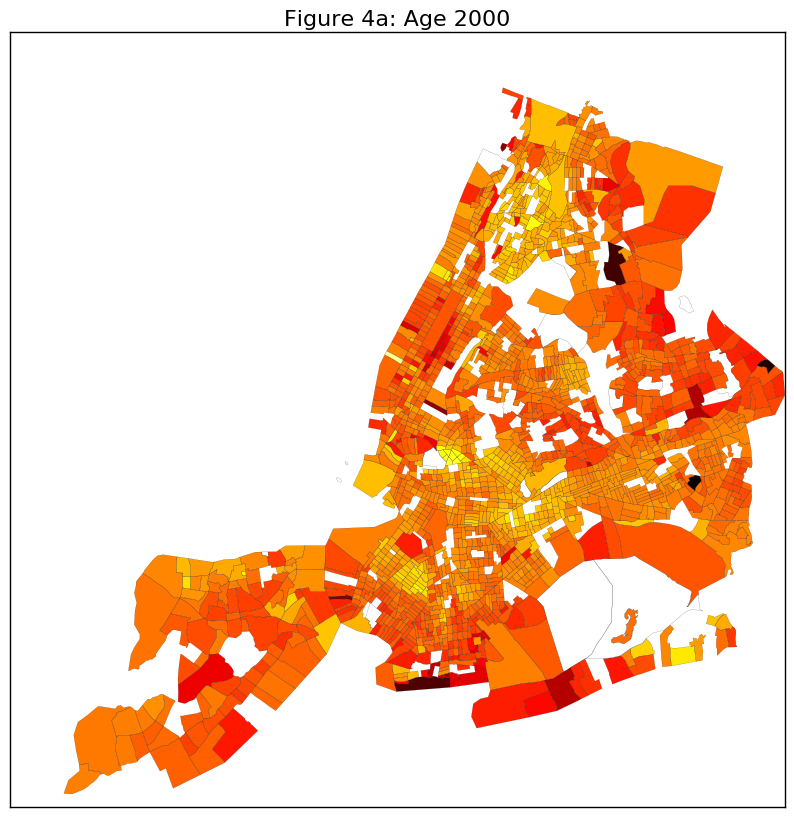

In [49]:
#http://matplotlib.org/examples/pylab_examples/subplots_demo.html

f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features00.plot(column = 'age', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4a: Age 2000", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


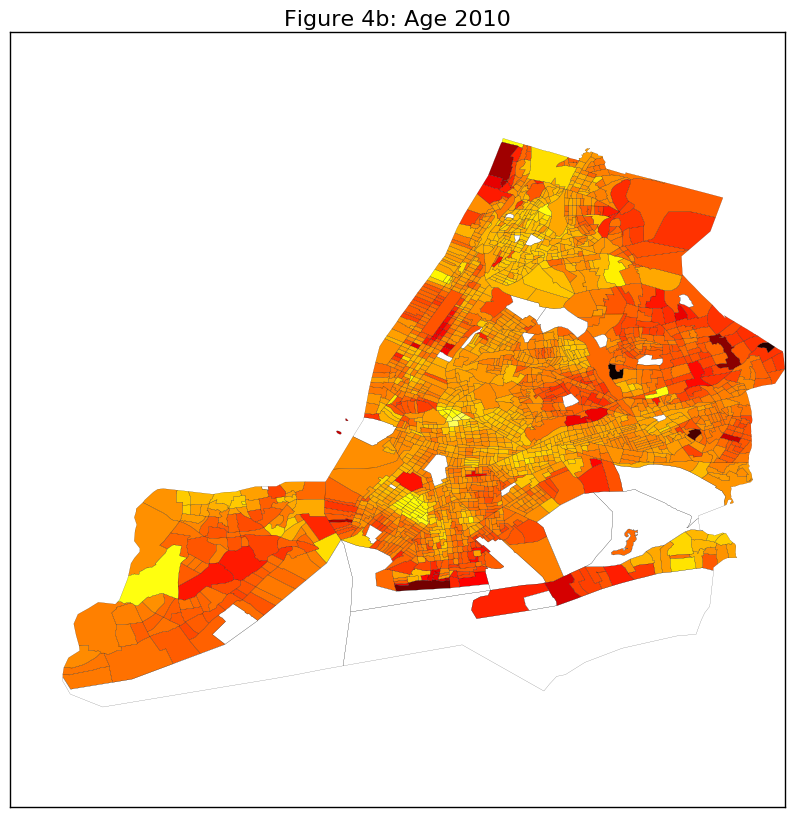

In [50]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features10.plot(column = 'age', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4b: Age 2010", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


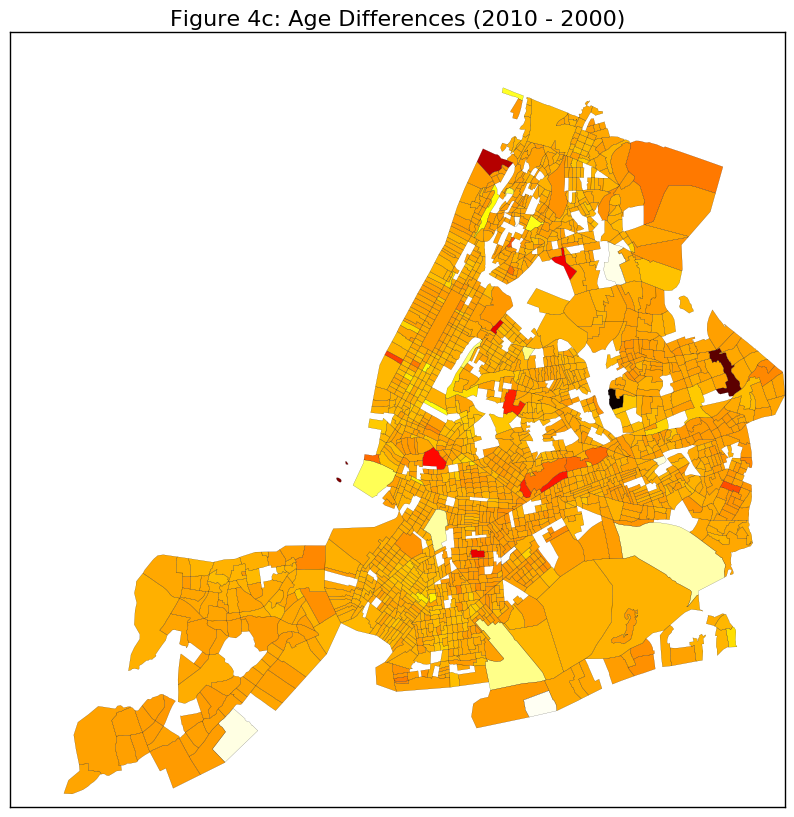

In [51]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features_diff.plot(column = 'age', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 4c: Age Differences (2010 - 2000)", fontsize = 16)

In [ ]:
# COME BACK LATER and add figure captions

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


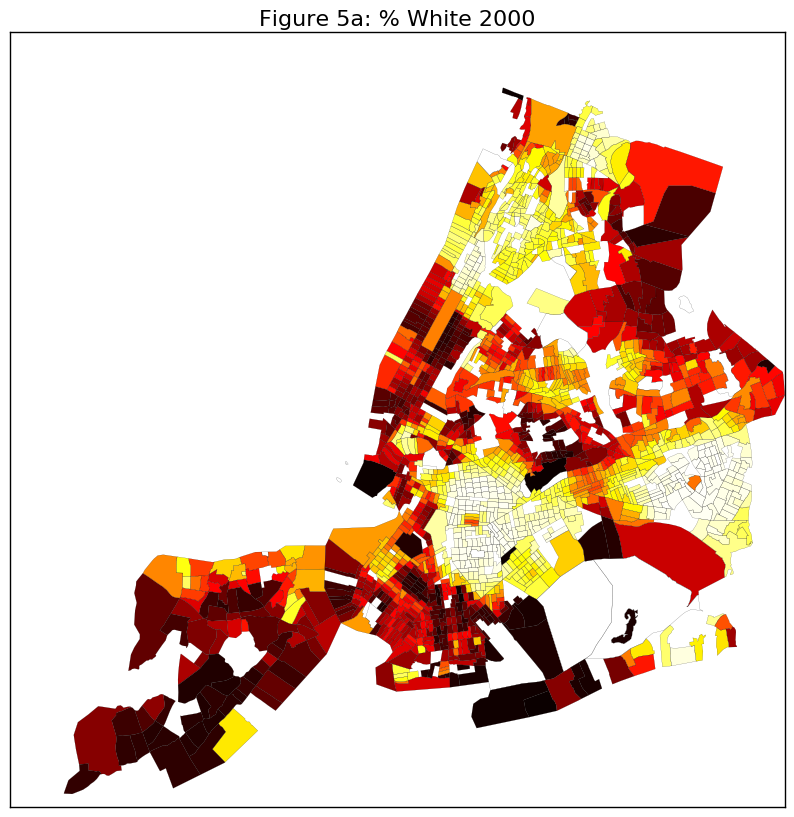

In [52]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features00.plot(column = 'diversity', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 5a: % White 2000", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


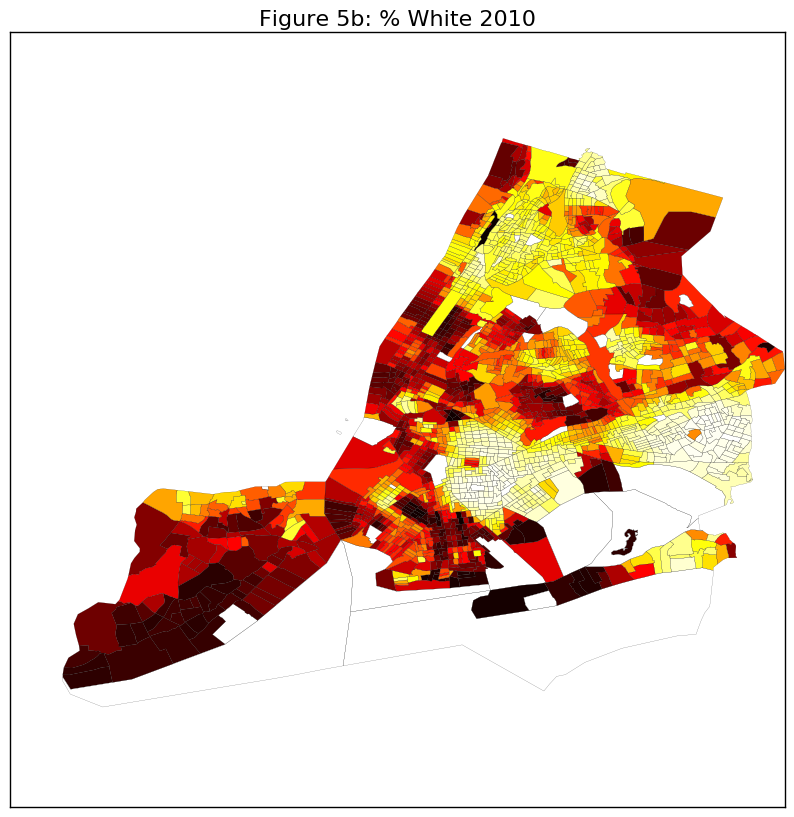

In [53]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features10.plot(column = 'diversity', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 5b: % White 2010", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


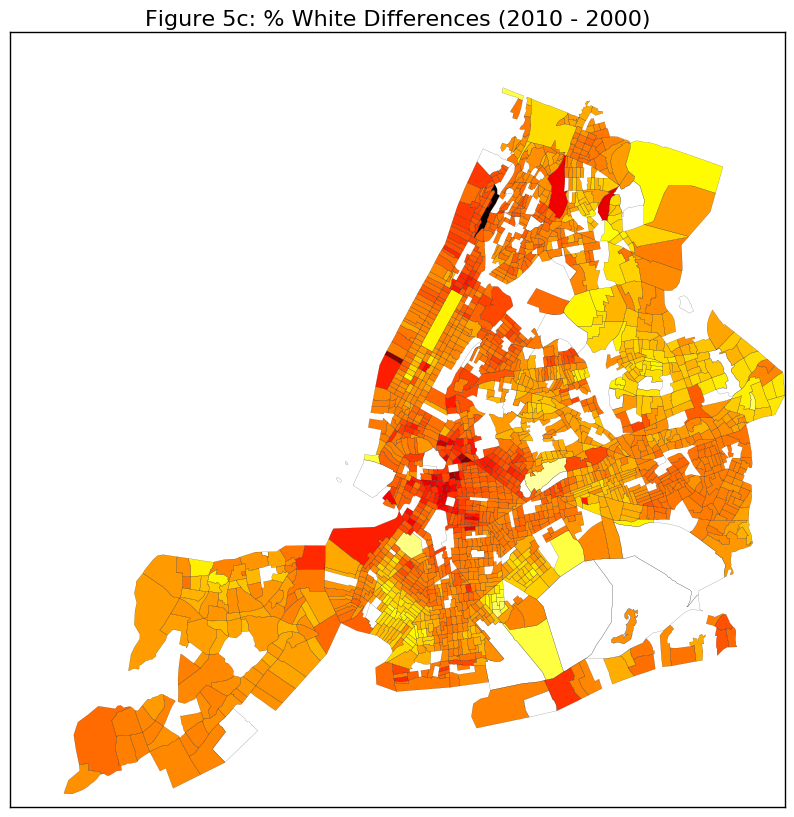

In [54]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features_diff.plot(column = 'diversity', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 5c: % White Differences (2010 - 2000)", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


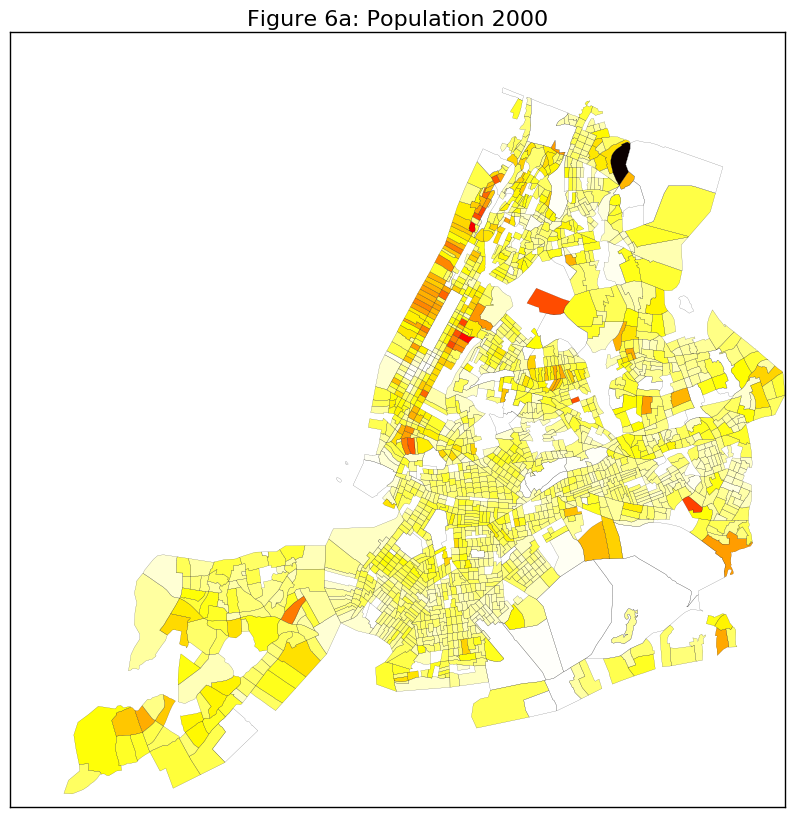

In [56]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features00.plot(column = 'population', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 6a: Population 2000", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


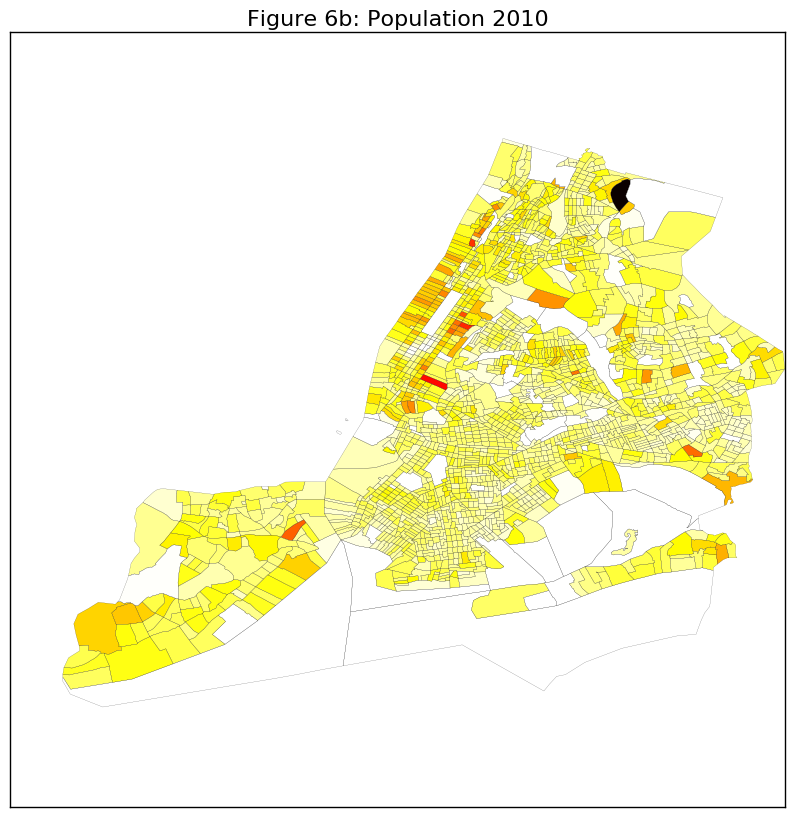

In [57]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features10.plot(column = 'population', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 6b: Population 2010", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


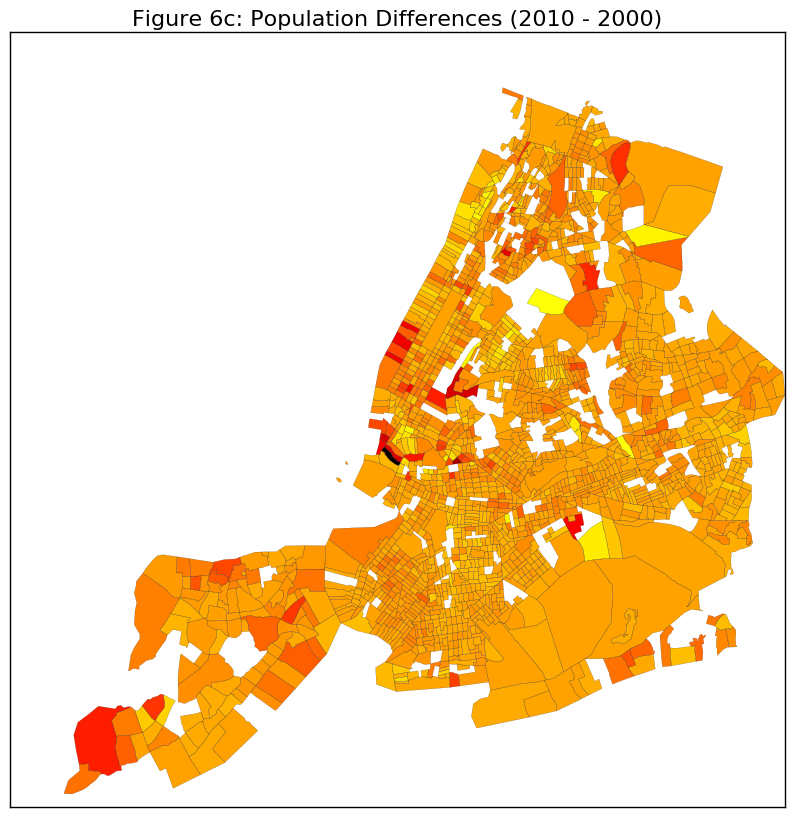

In [58]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features_diff.plot(column = 'population', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 6c: Population Differences (2010 - 2000)", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


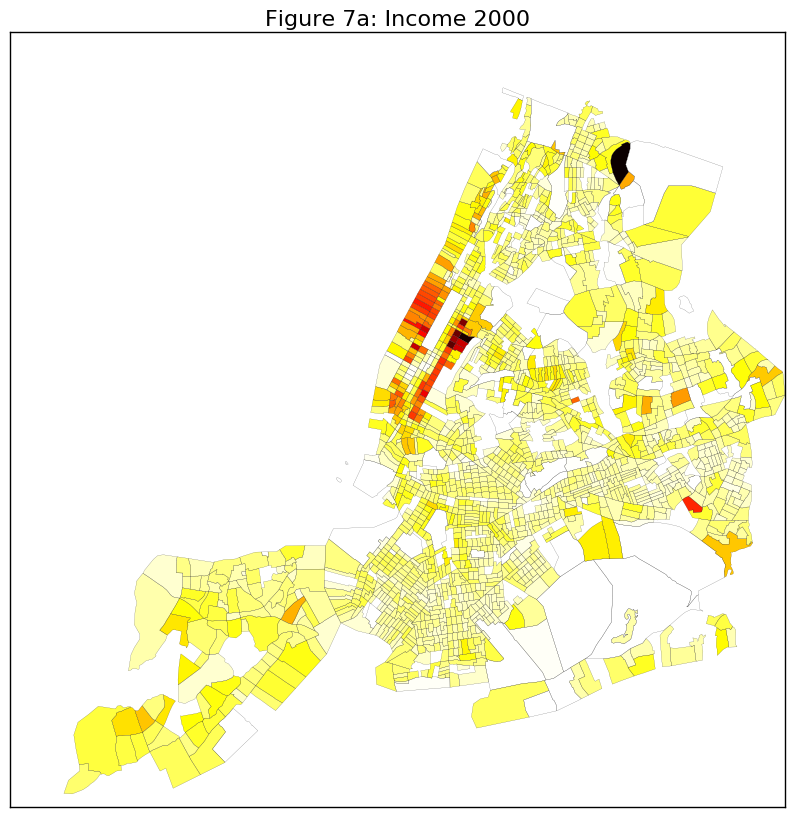

In [59]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features00.plot(column = 'income', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 7a: Income 2000", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


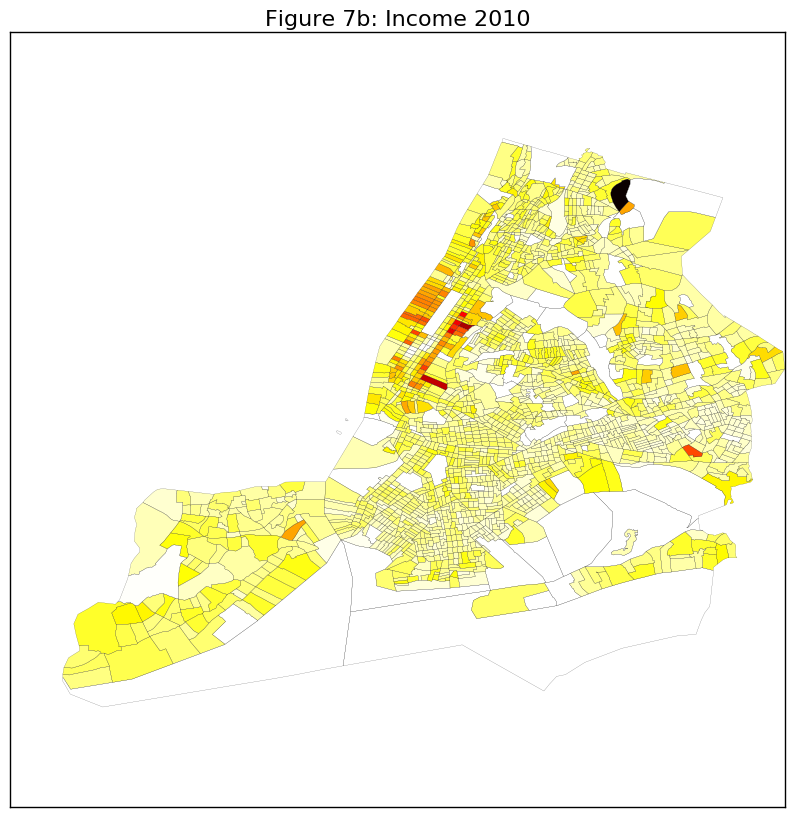

In [60]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features10.plot(column = 'income', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 7b: Income 2010", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


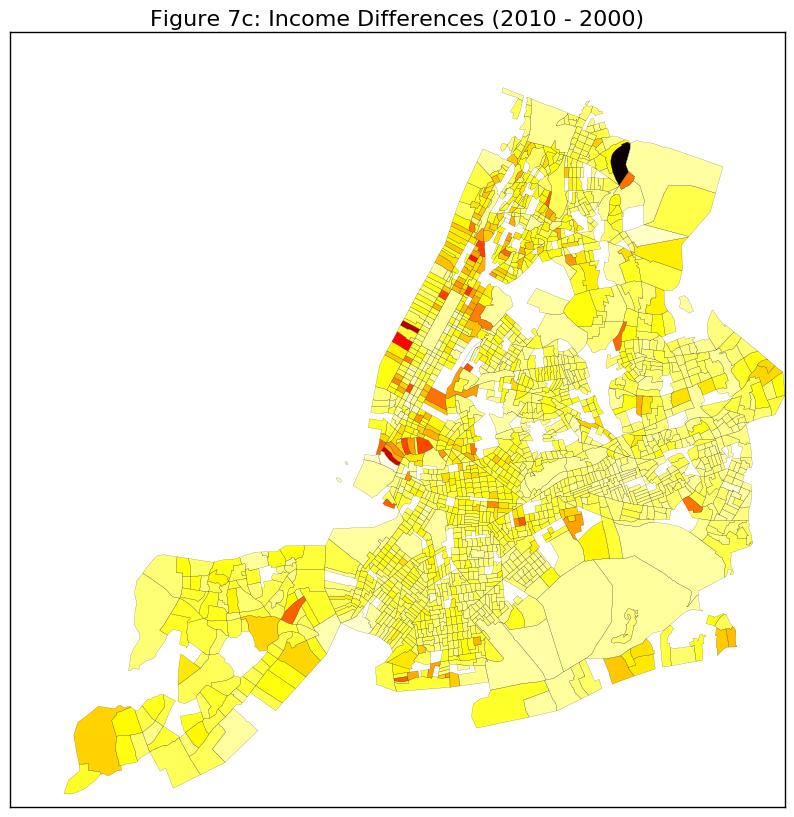

In [61]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

features_diff.plot(column = 'income', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 7c: Income Differences (2010 - 2000)", fontsize = 16)

## Step 10:
### Aggregate the census four features at the zipcode level and merge the zipcode dataframe

In [ ]:
# willl need a new shapefile now with geometries by zip code
# https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
# https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data

!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip

In [62]:
zip_shapefile = GeoDataFrame.from_file("ZIP_CODE_040114.shp")
zip_shapefile = zip_shapefile[['AREA', 'POPULATION', 'ZIPCODE', 'geometry']]
zip_shapefile.rename(columns = {"ZIPCODE": "ZIP"}, inplace = True)
zip_shapefile.head()

AREA  POPULATION    ZIP  \
0  2.269930e+07     18681.0  11436   
1  2.963100e+07     62426.0  11213   
2  4.197210e+07     83866.0  11212   
3  2.369863e+07     56527.0  11225   
4  3.686880e+07     72280.0  11218   

                                            geometry  
0  POLYGON ((1038098.251871482 188138.3800067157,...  
1  POLYGON ((1001613.712964058 186926.4395172149,...  
2  POLYGON ((1011174.275535807 183696.33770971, 1...  
3  POLYGON ((995908.3654508889 183617.6128015518,...  
4  POLYGON ((991997.1134308875 176307.4958601296,...

In [63]:
## DELETE LATER??

# 4th Quarter 2010 file with ZIP to CT data downloaded from: https://www.huduser.gov/portal/datasets/usps_crosswalk.html

#zip_ct = pd.read_excel('ZIP_TRACT_122010.xlsx')
#zip_ct = zip_ct[['ZIP', 'TRACT']]
#zip_ct.head()

ZIP        TRACT
0  501  36103158607
1  544  36103158607
2  601  72001956300
3  601  72001956600
4  601  72001956700

In [64]:
business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  EST00  EST10  zip_area        Dens00        Dens10     DensDiff  
0  11372   1409   1629   0.08228  17124.465233  19798.263921  2673.798688  
1  11004    189    229   0.08228   2297.036146   2783.181362   486.145216  
2  11040   1350   1494   0.08228  16407.401040  18157.523817  1750.122778  
3  11426    213    248   0.08228   2588.723275   3014.100339   425.377064  
4  11365    553    643   0.08228   6720.957611   7814.784347  1093.826736

In [65]:
business.dtypes

Shape_Area    float64
borough        object
geometry       object
ZIP             int64
EST00           int64
EST10           int64
zip_area      float64
Dens00        float64
Dens10        float64
DensDiff      float64
dtype: object

In [66]:
zip_ct.dtypes

ZIP      int64
TRACT    int64
dtype: object

In [67]:
zip_ct.rename(columns = {"TRACT": "GEOID10"}, inplace = True)
zip_ct.head()

ZIP      GEOID10
0  501  36103158607
1  544  36103158607
2  601  72001956300
3  601  72001956600
4  601  72001956700

In [68]:
business = pd.merge(business, zip_ct, how='inner', on=['ZIP'])

In [69]:
business['GEOID9'] = business['GEOID10'].astype(str)
business.dtypes

Shape_Area    float64
borough        object
geometry       object
ZIP             int64
EST00           int64
EST10           int64
zip_area      float64
Dens00        float64
Dens10        float64
DensDiff      float64
GEOID10         int64
GEOID9         object
dtype: object

In [70]:
#business.rename(columns = {"TRACT": "GEOID10"}, inplace = True)
business['GEOID9'] = business['GEOID9'].str[-9:]
business.drop('GEOID10', axis=1, inplace=True)
business.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
2  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
3  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
4  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   

     ZIP  EST00  EST10  zip_area        Dens00        Dens10     DensDiff  \
0  11372   1409   1629   0.08228  17124.465233  19798.263921  2673.798688   
1  11372   1409   1629   0.08228  17124.465233  19798.263921  2673.798688   
2  11372   1409   1629   0.08228  17124.465233  19798.263921  2673.798688   
3  11372   1409   1629   0.08228  17124.465233  19798.263921  2673.798688   
4  11372   1409   1629   0.08228  17124.465233  19798.263921  2673.798688   

      GEOID9  
0  081026500  
1  081026700  
2  081026900  
3  081027100  
4  081027300

In [71]:
zip_features00 = pd.merge(business, features00, how='inner', on=['GEOID9'])
zip_features00 = zip_features00[['ZIP', 'GEOID9', 'geometry_x', 'EST00', 'Dens00', 'age', 'diversity', 'income', 'population']]
zip_features00.head()

ZIP     GEOID9                                         geometry_x  EST00  \
0  11372  081026500  POLYGON ((-73.86942457284175 40.74915687096787...   1409   
1  11373  081026500  POLYGON ((-73.88722098467157 40.72752618766134...   1244   
2  11377  081026500  POLYGON ((-73.90202516735927 40.76741680457718...   1420   
3  11372  081026700  POLYGON ((-73.86942457284175 40.74915687096787...   1409   
4  11373  081026700  POLYGON ((-73.88722098467157 40.72752618766134...   1244   

         Dens00   age  diversity  income  population  
0  17124.465233  33.3       24.3    1270        4534  
1  15119.116217  33.3       24.3    1270        4534  
2  17258.155168  33.3       24.3    1270        4534  
3  17124.465233  32.5       30.9    1767        6415  
4  15119.116217  32.5       30.9    1767        6415

In [72]:
# ZIP codes repeat several times (since each zip code contains several CTs)
# Need to find averages for age, diversity, and income and sum for population by zip code

In [73]:
# http://stackoverflow.com/questions/34734940/in-pandas-how-to-get-average-of-several-column-values-for-each-row-in-data-fram
temp = zip_features00.groupby("ZIP")['Dens00', 'age', 'diversity', 'income'].mean()
temp = temp.reset_index(drop = False)

# http://stackoverflow.com/questions/16038760/python-find-average-for-columns-with-unique-matching-value-in-nested-list
# http://stackoverflow.com/questions/34657183/adding-rows-that-have-the-same-column-value-in-a-pandas-dataframe
temp2 = zip_features00.groupby("ZIP")['EST00', 'population'].sum()
# http://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-data-frame
temp2 = temp2.reset_index(drop = False)


zip00 = pd.merge(temp, temp2, how='inner', on=['ZIP'])
zip00.rename(columns = {"Dens00": "Dens00_ave", "age": "age_ave", "diversity": "diversity_ave", 'income' : 'income_ave', 
                        }, inplace = True)
zip00.head()

ZIP    Dens00_ave    age_ave  diversity_ave   income_ave  EST00  \
0  10001  88928.113635  36.675000      65.791667  1135.500000  87804   
1  10002  27673.816420  36.594444      39.883333  1383.611111  40986   
2  10003  44761.820762  34.153846      78.500000  2497.692308  47879   
3  10004  15726.797737  31.725000      70.700000   495.000000  20704   
4  10005  15641.722324  28.500000      68.633333   728.666667   3861   

   population  
0       31119  
1       95199  
2       67371  
3       15500  
4        5176

In [74]:
zip_features10 = pd.merge(business, features10, how='inner', on=['GEOID9'])
zip_features10 = zip_features10[['ZIP', 'GEOID9', 'geometry_x', 'EST10', 'Dens10', 'age', 'diversity', 'income', 'population']]

temp = zip_features10.groupby("ZIP")['Dens10', 'age', 'diversity', 'income'].mean()
temp = temp.reset_index(drop = False)

temp2 = zip_features10.groupby("ZIP")['EST10', 'population'].sum()
temp2 = temp2.reset_index(drop = False)

zip10 = pd.merge(temp, temp2, how='inner', on=['ZIP'])
zip10.rename(columns = {"Dens10": "Dens10_ave", "age": "age_ave", "diversity": "diversity_ave", 'income' : 'income_ave', 
                        }, inplace = True)
zip10.head()

ZIP    Dens10_ave    age_ave  diversity_ave   income_ave  EST10  \
0  10001  88004.437724  34.683333      63.500000  1674.750000  86892   
1  10002  34905.226508  39.638889      42.050000  2067.833333  51696   
2  10003  49987.881834  33.315385      77.284615  2624.769231  53469   
3  10004  16990.775299  34.150000      63.650000  1342.500000  22368   
4  10005  15386.496086  34.266667      59.233333  1811.000000   3798   

   population  
0       39546  
1       90840  
2       69833  
3       53320  
4       15596

In [75]:
features_diff['ESTDiff'] = zip10['EST10'] - zip00['EST00']
features_diff.head()

GEOID9                                           geometry  age  \
0  085001700  POLYGON ((-74.085082 40.63469100000003, -74.08...  0.3   
1  085000600  POLYGON ((-74.04907499999996 40.61483000000004...  6.8   
2  085000700  POLYGON ((-74.09125299999988 40.64944400000002...  3.6   
3  085001800  POLYGON ((-74.04632599999997 40.60273200000006... -0.5   
4  085000300  POLYGON ((-74.05623299999991 40.63817699999998...  8.6   

   diversity  income  population county  ESTDiff  
0       -1.5      84         116    085   -912.0  
1       -6.6     424         -60    085  10710.0  
2        1.5     556         -32    085   5590.0  
3        3.6     -67        -333    085   1664.0  
4       14.1     375         185    085    -63.0

In [76]:
zip_features_diff = pd.merge(business, features_diff, how='inner', on=['GEOID9'])
zip_features_diff = zip_features_diff[['ZIP', 'GEOID9', 'geometry_x', 'DensDiff', 'age', 'diversity', 'income', 'population', 'ESTDiff']]

temp = zip_features_diff.groupby("ZIP")['DensDiff', 'age', 'diversity', 'income'].mean()
temp = temp.reset_index(drop = False)

temp2 = zip_features_diff.groupby("ZIP")['ESTDiff', 'population'].sum()
temp2 = temp2.reset_index(drop = False)

zip_diff = pd.merge(temp, temp2, how='inner', on=['ZIP'])
zip_diff.rename(columns = {"DensDiff": "DensDiff_ave", "age": "age_ave", "diversity": "diversity_ave", 'income' : 'income_ave', 
                        }, inplace = True)
zip_diff.head()

ZIP  DensDiff_ave   age_ave  diversity_ave   income_ave  ESTDiff  \
0  10001   -923.675910 -1.991667      -2.291667   539.250000   7730.0   
1  10002   7231.410088  3.044444       2.166667   684.222222  19151.0   
2  10003   5226.061072 -0.838462      -1.215385   127.076923      NaN   
3  10004   1263.977562  2.425000      -7.050000   847.500000  15640.0   
4  10005   -255.226238  5.766667      -9.400000  1082.333333   4450.0   

   population  
0        8427  
1       -4359  
2        2462  
3       37820  
4       10420

In [77]:
zip_shapefile.dtypes

AREA          float64
POPULATION    float64
ZIP            object
geometry       object
dtype: object

In [78]:
zip00.dtypes

ZIP                int64
Dens00_ave       float64
age_ave          float64
diversity_ave    float64
income_ave       float64
EST00              int64
population         int64
dtype: object

In [79]:
zip_shapefile['ZIP'] = pd.to_numeric(zip_shapefile['ZIP'])
zip_shapefile.dtypes

AREA          float64
POPULATION    float64
ZIP             int64
geometry       object
dtype: object

In [80]:
zip00_shape = pd.merge(zip00, zip_shapefile, how = 'inner', on = ['ZIP'])
zip10_shape = pd.merge(zip10, zip_shapefile, how = 'inner', on = ['ZIP'])
zip_diff_shape = pd.merge(zip_diff, zip_shapefile, how = 'inner', on = ['ZIP'])

In [81]:
# Something funny happened when calculating my (lowercase) population value - could simply be different population definitions.
# Going to drop it, since a quick google search of a few zip codes supports the POPULATION column that came from the zip code
# shapefile

zip00_shape.drop('population', axis=1, inplace=True)
zip00_shape.head()

ZIP    Dens00_ave    age_ave  diversity_ave   income_ave  EST00  \
0  10001  88928.113635  36.675000      65.791667  1135.500000  87804   
1  10002  27673.816420  36.594444      39.883333  1383.611111  40986   
2  10003  44761.820762  34.153846      78.500000  2497.692308  47879   
3  10004  15726.797737  31.725000      70.700000   495.000000  20704   
4  10004  15726.797737  31.725000      70.700000   495.000000  20704   

           AREA  POPULATION                                           geometry  
0  1.779494e+07     22413.0  POLYGON ((981958.6472873986 213464.4530421346,...  
1  2.628013e+07     81305.0  POLYGON ((991339.8703228086 207576.7837151289,...  
2  1.553838e+07     55878.0  POLYGON ((989830.469142139 207048.1263078749, ...  
3  4.002521e+06      2187.0  POLYGON ((981197.408652395 196571.0816452205, ...  
4  1.202708e+06      2187.0  POLYGON ((972696.8446168154 193014.5477478057,...

In [82]:
len(zip00_shape)

242

In [83]:
#zip00_shape = zip00_shape[np.isfinite(zip00_shape['age_ave'])]
#len(zip00_shape)
# Above(hashed) code showed no drop in length (no missing values)

zip00_shape = zip00_shape[np.isfinite(zip00_shape['diversity_ave'])]
len(zip00_shape)

239

In [84]:
zip00_shape = zip00_shape[np.isfinite(zip00_shape['income_ave'])]
len(zip00_shape)

239

In [85]:
zip00_shape = zip00_shape[np.isfinite(zip00_shape['EST00'])]
len(zip00_shape)

239

In [86]:
zip00_shape = zip00_shape[np.isfinite(zip00_shape['POPULATION'])]
len(zip00_shape)

239

In [87]:
# Lost 3 missing values, total Zip Codes with data 2010 = 239

In [88]:
zip10_shape.drop('population', axis=1, inplace=True)
zip10_shape.head()

ZIP    Dens10_ave    age_ave  diversity_ave   income_ave  EST10  \
0  10001  88004.437724  34.683333      63.500000  1674.750000  86892   
1  10002  34905.226508  39.638889      42.050000  2067.833333  51696   
2  10003  49987.881834  33.315385      77.284615  2624.769231  53469   
3  10004  16990.775299  34.150000      63.650000  1342.500000  22368   
4  10004  16990.775299  34.150000      63.650000  1342.500000  22368   

           AREA  POPULATION                                           geometry  
0  1.779494e+07     22413.0  POLYGON ((981958.6472873986 213464.4530421346,...  
1  2.628013e+07     81305.0  POLYGON ((991339.8703228086 207576.7837151289,...  
2  1.553838e+07     55878.0  POLYGON ((989830.469142139 207048.1263078749, ...  
3  4.002521e+06      2187.0  POLYGON ((981197.408652395 196571.0816452205, ...  
4  1.202708e+06      2187.0  POLYGON ((972696.8446168154 193014.5477478057,...

In [89]:
len(zip10_shape)

242

In [90]:
zip10_shape = zip10_shape[np.isfinite(zip10_shape['age_ave'])]
len(zip10_shape)

242

In [91]:
zip10_shape = zip10_shape[np.isfinite(zip10_shape['diversity_ave'])]
len(zip10_shape)

239

In [92]:
zip10_shape = zip10_shape[np.isfinite(zip10_shape['income_ave'])]
len(zip10_shape)

239

In [93]:
zip10_shape = zip10_shape[np.isfinite(zip10_shape['EST10'])]
len(zip10_shape)

239

In [94]:
zip10_shape = zip10_shape[np.isfinite(zip10_shape['POPULATION'])]
len(zip10_shape)

239

In [95]:
# Same for 2010: down to 241 zip codes with data

In [96]:
zip_diff_shape.drop('population', axis=1, inplace=True)
zip_diff_shape.head()

ZIP  DensDiff_ave   age_ave  diversity_ave  income_ave  ESTDiff  \
0  10001   -923.675910 -1.991667      -2.291667  539.250000   7730.0   
1  10002   7231.410088  3.044444       2.166667  684.222222  19151.0   
2  10003   5226.061072 -0.838462      -1.215385  127.076923      NaN   
3  10004   1263.977562  2.425000      -7.050000  847.500000  15640.0   
4  10004   1263.977562  2.425000      -7.050000  847.500000  15640.0   

           AREA  POPULATION                                           geometry  
0  1.779494e+07     22413.0  POLYGON ((981958.6472873986 213464.4530421346,...  
1  2.628013e+07     81305.0  POLYGON ((991339.8703228086 207576.7837151289,...  
2  1.553838e+07     55878.0  POLYGON ((989830.469142139 207048.1263078749, ...  
3  4.002521e+06      2187.0  POLYGON ((981197.408652395 196571.0816452205, ...  
4  1.202708e+06      2187.0  POLYGON ((972696.8446168154 193014.5477478057,...

In [97]:
zip_diff_shape = zip_diff_shape[np.isfinite(zip_diff_shape['diversity_ave'])]
len(zip_diff_shape)

238

In [98]:
zip10_shape = zip10_shape[np.isfinite(zip10_shape['diversity_ave'])]
len(zip10_shape)

239

# MAP these all same as before - 
### figure out the subplot thing so it's cleaner?

## Cluster the zip codes on these four features (using a Eucledian distance)

In [99]:

import numpy as np
from sklearn.cluster import KMeans

In [100]:
zip00_shape.dtypes

ZIP                int64
Dens00_ave       float64
age_ave          float64
diversity_ave    float64
income_ave       float64
EST00              int64
AREA             float64
POPULATION       float64
geometry          object
dtype: object

In [101]:
import sklearn.cluster
import numpy as np

In [102]:
zip_matrix00 = zip00_shape.as_matrix(columns=['ZIP', 'age_ave', 'diversity_ave', 'income_ave', 'POPULATION', 'Dens00_ave'])
zip_matrix00.shape

(239, 6)

In [103]:
scp.vq.whiten(zip_matrix00)
zip_matrix00.shape

(239, 6)

###  Sklearn creates default initial centers for kmeans, but since I want to use the same initial centers for both years, I'm going to create my own based off the 2000 data. 
### To do this, I'm going to take the 0th, 25th, 50th, 75th, and 100th percentiles for each feature from 2000 (post-whitening) and use those as my 5 initial centers for each of the 5 features, created the required (n_clusters, n_features) array for the Sklearn K means init function. These centers will be used for both years. 

In [239]:
zip_features_2000 = pd.DataFrame(zip_matrix00)
zip_features_2000.head()

0          1          2            3        4             5
0  10001.0  36.675000  65.791667  1135.500000  22413.0  88928.113635
1  10002.0  36.594444  39.883333  1383.611111  81305.0  27673.816420
2  10003.0  34.153846  78.500000  2497.692308  55878.0  44761.820762
3  10004.0  31.725000  70.700000   495.000000   2187.0  15726.797737
4  10004.0  31.725000  70.700000   495.000000   2187.0  15726.797737

In [279]:
a = zip_features_2000[1].quantile(.0)
b = zip_features_2000[2].quantile(.0)
c = zip_features_2000[3].quantile(.0) 
d = zip_features_2000[4].quantile(.0)
e = zip_features_2000[5].quantile(.0)
    
f = zip_features_2000[1].quantile(.25)
g = zip_features_2000[2].quantile(.25)
h = zip_features_2000[3].quantile(.25) 
i = zip_features_2000[4].quantile(.25)
j = zip_features_2000[5].quantile(.25)
    
k = zip_features_2000[1].quantile(.50)
l = zip_features_2000[2].quantile(.50)
m = zip_features_2000[3].quantile(.50) 
n = zip_features_2000[4].quantile(.50)
o = zip_features_2000[5].quantile(.50)

p = zip_features_2000[1].quantile(.75)
q = zip_features_2000[2].quantile(.75)
r = zip_features_2000[3].quantile(.75) 
s = zip_features_2000[4].quantile(.75)
t = zip_features_2000[5].quantile(.75)

u = zip_features_2000[1].quantile(1.0)
v = zip_features_2000[2].quantile(1.0)
w = zip_features_2000[3].quantile(1.0) 
x = zip_features_2000[4].quantile(1.0)
y = zip_features_2000[5].quantile(1.0)

In [280]:
init_centers = np.array([[a, b, c, d, e], [f, g, h, i, j], [k, l, m, n, o], [p, q, r, s, t], [u, v, w, x, y]])
init_centers.shape

(5, 5)

In [281]:
init_centers.dtype

dtype('float64')

In [282]:
# Creating a random array of (n_clusters, n_features) to use as initial centers for both years, so clusters are comparable.
#centers = np.random.rand(4,5)
#np.random.seed(444)

## remove cell later

In [284]:
# http://stackoverflow.com/questions/21212484/python-relating-k-means-cluster-to-instance

labels = [x[0] for x in zip_matrix00]
a = np.array([x[1:] for x in zip_matrix00])
clust_centers = 5

model00 = sklearn.cluster.k_means(a, clust_centers, random_state = 444, init = init_centers)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10


In [285]:
clusters00 = dict(zip(labels, model00[1]))

In [286]:
clusters00

{10001.0: 4,
 10002.0: 3,
 10003.0: 4,
 10004.0: 0,
 10005.0: 0,
 10006.0: 0,
 10007.0: 0,
 10009.0: 2,
 10010.0: 4,
 10011.0: 4,
 10012.0: 1,
 10013.0: 4,
 10014.0: 1,
 10016.0: 4,
 10017.0: 4,
 10018.0: 4,
 10019.0: 4,
 10020.0: 0,
 10021.0: 4,
 10022.0: 4,
 10023.0: 2,
 10024.0: 2,
 10025.0: 3,
 10026.0: 1,
 10027.0: 2,
 10028.0: 2,
 10029.0: 3,
 10030.0: 1,
 10031.0: 2,
 10032.0: 2,
 10033.0: 2,
 10034.0: 1,
 10035.0: 1,
 10036.0: 4,
 10037.0: 0,
 10038.0: 1,
 10039.0: 1,
 10040.0: 1,
 10041.0: 0,
 10043.0: 0,
 10045.0: 0,
 10055.0: 0,
 10069.0: 0,
 10081.0: 0,
 10103.0: 0,
 10104.0: 0,
 10105.0: 0,
 10106.0: 0,
 10107.0: 0,
 10110.0: 0,
 10111.0: 0,
 10112.0: 0,
 10118.0: 0,
 10119.0: 0,
 10120.0: 0,
 10121.0: 0,
 10122.0: 0,
 10123.0: 0,
 10128.0: 2,
 10151.0: 0,
 10152.0: 0,
 10153.0: 0,
 10154.0: 0,
 10155.0: 0,
 10158.0: 0,
 10162.0: 0,
 10165.0: 0,
 10166.0: 0,
 10167.0: 0,
 10168.0: 0,
 10169.0: 0,
 10170.0: 0,
 10171.0: 0,
 10172.0: 0,
 10173.0: 0,
 10174.0: 0,
 10175.0: 0,

In [287]:
clusters00 = pd.DataFrame([clusters00]).T
clusters00.rename(columns = {0: "Cluster2000"}, inplace = True)
clusters00.head(20)

Cluster2000
10001.0            4
10002.0            3
10003.0            4
10004.0            0
10005.0            0
10006.0            0
10007.0            0
10009.0            2
10010.0            4
10011.0            4
10012.0            1
10013.0            4
10014.0            1
10016.0            4
10017.0            4
10018.0            4
10019.0            4
10020.0            0
10021.0            4
10022.0            4

In [288]:
clusters00 = clusters00.reset_index(drop = False)
clusters00.rename(columns = {'index': "ZIP"}, inplace = True)
clusters00.head()

ZIP  Cluster2000
0  10001.0            4
1  10002.0            3
2  10003.0            4
3  10004.0            0
4  10005.0            0

In [289]:
zip_matrix10 = zip10_shape.as_matrix(columns=['ZIP', 'age_ave', 'diversity_ave', 'income_ave', 'POPULATION', 'Dens10_ave'])
zip_matrix10.shape

(239, 6)

In [290]:
scp.vq.whiten(zip_matrix10)
zip_matrix10.shape

(239, 6)

In [292]:
labels = [x[0] for x in zip_matrix10]
a = np.array([x[1:] for x in zip_matrix10])
clust_centers = 5

model10 = sklearn.cluster.k_means(a, clust_centers, random_state = 444, init = init_centers)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10


In [293]:
clusters10 = dict(zip(labels, model10[1]))

In [294]:
clusters10

{10001.0: 4,
 10002.0: 3,
 10003.0: 4,
 10004.0: 0,
 10005.0: 0,
 10006.0: 0,
 10007.0: 0,
 10009.0: 3,
 10010.0: 2,
 10011.0: 4,
 10012.0: 2,
 10013.0: 4,
 10014.0: 2,
 10016.0: 4,
 10017.0: 4,
 10018.0: 4,
 10019.0: 4,
 10020.0: 0,
 10021.0: 4,
 10022.0: 4,
 10023.0: 3,
 10024.0: 2,
 10025.0: 3,
 10026.0: 2,
 10027.0: 2,
 10028.0: 2,
 10029.0: 3,
 10030.0: 1,
 10031.0: 2,
 10032.0: 2,
 10033.0: 2,
 10034.0: 2,
 10035.0: 2,
 10036.0: 4,
 10037.0: 1,
 10038.0: 1,
 10039.0: 1,
 10040.0: 2,
 10041.0: 0,
 10043.0: 0,
 10045.0: 0,
 10055.0: 0,
 10069.0: 0,
 10081.0: 0,
 10103.0: 0,
 10104.0: 0,
 10105.0: 0,
 10106.0: 0,
 10107.0: 0,
 10110.0: 0,
 10111.0: 0,
 10112.0: 0,
 10118.0: 0,
 10119.0: 0,
 10120.0: 0,
 10121.0: 0,
 10122.0: 0,
 10123.0: 0,
 10128.0: 2,
 10151.0: 0,
 10152.0: 0,
 10153.0: 0,
 10154.0: 0,
 10155.0: 0,
 10158.0: 0,
 10162.0: 0,
 10165.0: 0,
 10166.0: 0,
 10167.0: 0,
 10168.0: 0,
 10169.0: 0,
 10170.0: 0,
 10171.0: 0,
 10172.0: 0,
 10173.0: 0,
 10174.0: 0,
 10175.0: 0,

In [295]:
clusters10 = pd.DataFrame([clusters10]).T
clusters10.rename(columns = {0: "Cluster2010"}, inplace = True)
clusters10 = clusters10.reset_index(drop = False)
clusters10.rename(columns = {'index': "ZIP"}, inplace = True)
clusters10.head(20)

ZIP  Cluster2010
0   10001.0            4
1   10002.0            3
2   10003.0            4
3   10004.0            0
4   10005.0            0
5   10006.0            0
6   10007.0            0
7   10009.0            3
8   10010.0            2
9   10011.0            4
10  10012.0            2
11  10013.0            4
12  10014.0            2
13  10016.0            4
14  10017.0            4
15  10018.0            4
16  10019.0            4
17  10020.0            0
18  10021.0            4
19  10022.0            4

In [296]:
len(clusters00)

227

In [297]:
len(clusters10)

227

In [298]:
clusters_10year = pd.merge(clusters00, clusters10, how = 'inner', on = ['ZIP'])
clusters_10year.head()

ZIP  Cluster2000  Cluster2010
0  10001.0            4            4
1  10002.0            3            3
2  10003.0            4            4
3  10004.0            0            0
4  10005.0            0            0

## Step 9:
### Identify the zip codes that have changed cluster assignment (those that are now associated with a different group of zip codes) and show a choropleth of the clusters in 2010, 2000 and a choropleth of the cluster changes

In [299]:
# Creating a new column with 0 for no change in cluster, 1 for change in cluster
# http://chrisalbon.com/python/pandas_create_column_with_loop.html

changes = []
for i in range(len(clusters_10year)):
    if clusters_10year['Cluster2000'][i] == clusters_10year['Cluster2010'][i]:
        changes.append(0)
    else:
        changes.append(1)

clusters_10year['Cluster_Change'] = changes

In [300]:
clusters_10year.head()

ZIP  Cluster2000  Cluster2010  Cluster_Change
0  10001.0            4            4               0
1  10002.0            3            3               0
2  10003.0            4            4               0
3  10004.0            0            0               0
4  10005.0            0            0               0

## Chloropaths of Clusters and Changes

In [301]:
# merge the cluster df with shapefile geometries



In [302]:
zip_shape.head()

Shape_Area borough                                           geometry  \
0  2.016328e+07  Queens  POLYGON ((-73.86942457284175 40.74915687096787...   
1  2.260653e+07  Queens  POLYGON ((-73.71068374074007 40.75004039450917...   
2  6.269333e+06  Queens  POLYGON ((-73.70098278625547 40.73889569923034...   
3  4.941836e+07  Queens  POLYGON ((-73.72270447144122 40.75373371438336...   
4  6.938587e+07  Queens  POLYGON ((-73.81088634744755 40.72717187575918...   

     ZIP  
0  11372  
1  11004  
2  11040  
3  11426  
4  11365

In [303]:
zip_geom = zip_shape[['ZIP', 'geometry']]
zip_geom.head()

ZIP                                           geometry
0  11372  POLYGON ((-73.86942457284175 40.74915687096787...
1  11004  POLYGON ((-73.71068374074007 40.75004039450917...
2  11040  POLYGON ((-73.70098278625547 40.73889569923034...
3  11426  POLYGON ((-73.72270447144122 40.75373371438336...
4  11365  POLYGON ((-73.81088634744755 40.72717187575918...

In [304]:
clusters_10year.head()

ZIP  Cluster2000  Cluster2010  Cluster_Change
0  10001.0            4            4               0
1  10002.0            3            3               0
2  10003.0            4            4               0
3  10004.0            0            0               0
4  10005.0            0            0               0

In [305]:
zip_geom.dtypes

ZIP          int64
geometry    object
dtype: object

In [306]:
clusters_10year.dtypes

ZIP               float64
Cluster2000         int64
Cluster2010         int64
Cluster_Change      int64
dtype: object

In [307]:
clusters_10year.ZIP = clusters_10year.ZIP.astype(int)
clusters_10year.head()

ZIP  Cluster2000  Cluster2010  Cluster_Change
0  10001            4            4               0
1  10002            3            3               0
2  10003            4            4               0
3  10004            0            0               0
4  10005            0            0               0

In [308]:
clusters_10year = pd.merge(clusters_10year, zip_geom, how = 'inner', on = ['ZIP'])
clusters_10year.head()

ZIP  Cluster2000  Cluster2010  Cluster_Change  \
0  10001            4            4               0   
1  10002            3            3               0   
2  10003            4            4               0   
3  10004            0            0               0   
4  10004            0            0               0   

                                            geometry  
0  POLYGON ((-74.00827017711134 40.75258714368449...  
1  POLYGON ((-73.97441674489379 40.73642441865476...  
2  POLYGON ((-73.97986374196766 40.73497446573838...  
3  POLYGON ((-74.00596661578348 40.7043243225291,...  
4  POLYGON ((-74.04166368343016 40.69644987183209...

In [309]:
clusters_10year_gdf = gp.GeoDataFrame(clusters_10year, geometry = 'geometry')

In [310]:
type(clusters_10year_gdf)

geopandas.geodataframe.GeoDataFrame

In [311]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from numpy.random import randn

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


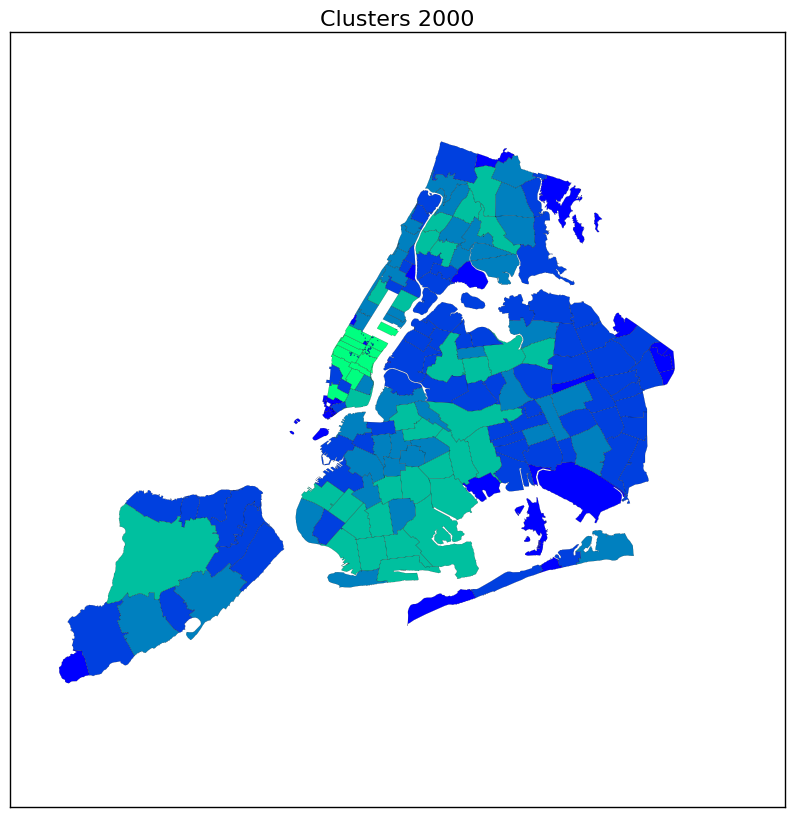

In [312]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
clusters_10year_gdf.plot(column ='Cluster2000' , colormap = 'winter', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Clusters 2000", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


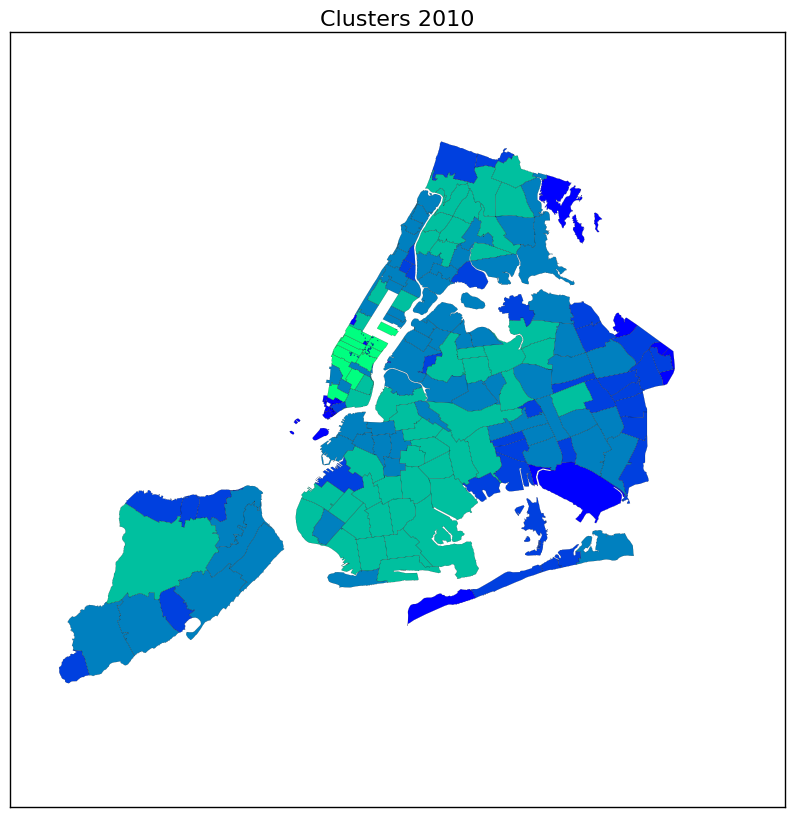

In [313]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
clusters_10year_gdf.plot(column ='Cluster2010' , colormap = 'winter', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Clusters 2010", fontsize = 16)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


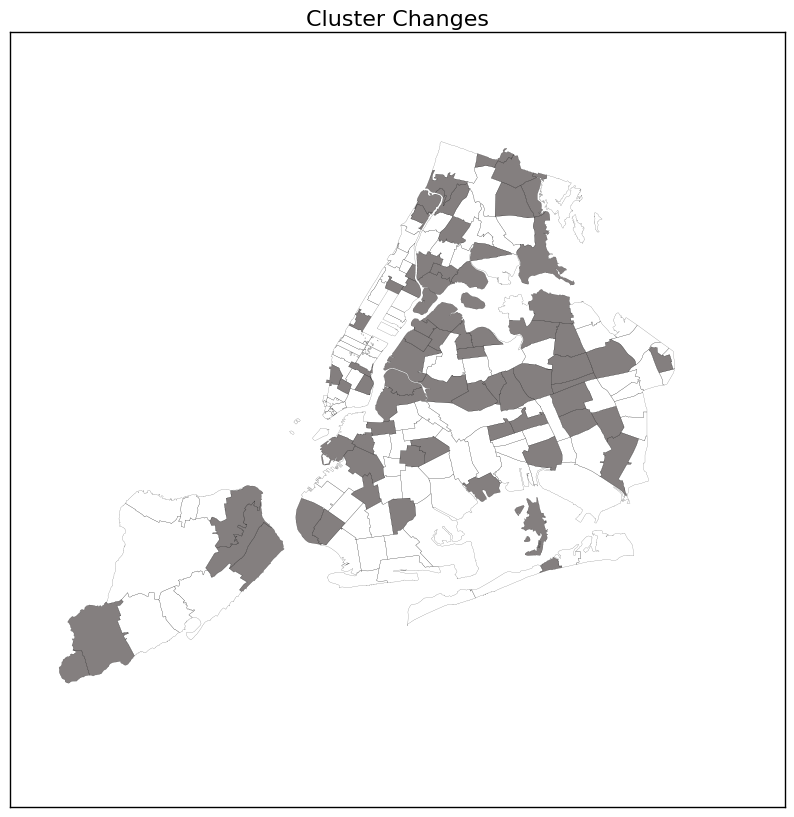

In [320]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
clusters_10year_gdf.plot(column ='Cluster_Change' , colormap = 'hot_r', alpha = 0.5, linewidth = 0.1, ax = ax)
plt.title("Cluster Changes", fontsize = 16)

### Cluster changes above shown in grey.

## Come back and make these maps better, and add captions

## Step 12:
### Define a function that given a dataframe containing the relevant information and two cluster labels finds if the zip code changed cluster assignments from the first to the second label, and if so finds the individual features that are significantly different as measured by Pearson's correlation, plot those zip codes, and plot a histogram of the features that have significantly changed. Run your function for all label pairs (2 points, one for the identification of locations that changed cluster and one for the identifiation of the features that changed significantly).

In [315]:
clusters_analysis = clusters_10year_gdf
clusters_analysis.head()

ZIP  Cluster2000  Cluster2010  Cluster_Change  \
0  10001            4            4               0   
1  10002            3            3               0   
2  10003            4            4               0   
3  10004            0            0               0   
4  10004            0            0               0   

                                            geometry  
0  POLYGON ((-74.00827017711134 40.75258714368449...  
1  POLYGON ((-73.97441674489379 40.73642441865476...  
2  POLYGON ((-73.97986374196766 40.73497446573838...  
3  POLYGON ((-74.00596661578348 40.7043243225291,...  
4  POLYGON ((-74.04166368343016 40.69644987183209...

In [316]:
# http://chrisalbon.com/python/pandas_dropping_column_and_rows.html
clusters_analysis = clusters_analysis[clusters_analysis.Cluster_Change != 0]
clusters_analysis.head()

ZIP  Cluster2000  Cluster2010  Cluster_Change  \
10  10009            2            3               1   
11  10010            4            2               1   
13  10012            1            2               1   
15  10014            1            2               1   
23  10023            2            3               1   

                                             geometry  
10  POLYGON ((-73.97345725954919 40.73070787427551...  
11  POLYGON ((-73.98774683765608 40.7440655536138,...  
13  POLYGON ((-73.99657214974589 40.72955224852642...  
15  POLYGON ((-74.00095441302535 40.73170612172334...  
23  POLYGON ((-73.99306672475984 40.77433850654827...

In [317]:
# shows number of zip codes that changed cluster assignment from 2000 to 2010
len(clusters_analysis)

76

In [318]:
clusters_analysis.Cluster2000.unique()

array([2, 4, 1, 0])

In [319]:
clusters_analysis.Cluster2010.unique()

array([3, 2, 1])

### The above unique values in each cluster column show that there were 10 pair types for changing cluster from 2000 to 2010:

1) Cluster 0 to 1 = Pair A

2) Cluster 0 to 2 = Pair B

3) Cluster 0 to 3 = Pair C

4) Cluster 1 to 2 = Pair D

5) Cluster 1 to 3 = Pair E

6) Cluster 2 to 1 = Pair F

7) Cluster 2 to 3 = Pair G

8) Cluster 4 to 1 = Pair H

9) Cluster 4 to 2 = Pair I

10) Cluster 4 to 3 = Pair J

In [329]:
# Had issues making a large loop to break down groups, so will split into smaller dataframes for each then combine them again later.

cluster0_00 = clusters_analysis[clusters_analysis.Cluster2000 == 0]
cluster1_00 = clusters_analysis[clusters_analysis.Cluster2000 == 1]
cluster2_00 = clusters_analysis[clusters_analysis.Cluster2000 == 2]
cluster4_00 = clusters_analysis[clusters_analysis.Cluster2000 == 4]

In [330]:
changes0 = []

for row in cluster0_00['Cluster2010']:
    if row == 1:
        changes0.append('A')
    elif row == 2:
        changes0.append('B')
    elif row == 3:
        changes0.append('C')
        
cluster0_00['Cluster_Change'] = changes0

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [333]:
changes1 = []

for row in cluster1_00['Cluster2010']:
    if row == 2:
        changes1.append('D')
    elif row == 3:
        changes1.append('E')
        
cluster1_00['Cluster_Change'] = changes1

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [334]:
changes2 = []

for row in cluster2_00['Cluster2010']:
    if row == 1:
        changes2.append('F')
    elif row == 3:
        changes2.append('G')
        
cluster2_00['Cluster_Change'] = changes2

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [335]:
changes4 = []

for row in cluster4_00['Cluster2010']:
    if row == 1:
        changes4.append('H')
    elif row == 2:
        changes4.append('I')
    elif row == 3:
        changes4.append('I')
        
cluster4_00['Cluster_Change'] = changes4

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [336]:
cluster_pairs = pd.concat((cluster0_00, cluster1_00, cluster2_00, cluster4_00), axis = 0)

In [337]:
len(cluster_pairs)

76

In [340]:
cluster_pairs.head()

ZIP  Cluster2000  Cluster2010 Cluster_Change  \
38   10037            0            1              A   
99   10307            0            1              A   
127  10470            0            1              A   
131  10474            0            1              A   
134  11004            0            1              A   

                                              geometry  
38   POLYGON ((-73.93382316715753 40.81949968615795...  
99   POLYGON ((-74.24966624246994 40.51555479573201...  
127  POLYGON ((-73.8779026157511 40.90555223733508,...  
131  POLYGON ((-73.89542858297601 40.81584469294005...  
134  POLYGON ((-73.71068374074007 40.75004039450917...

In [341]:
cluster_pairs.Cluster_Change.unique()

array(['A', 'D', 'G', 'I'], dtype=object)

### The above unique output shows that, in the end, there were only 4 of the cluster pair changes that occured (A, D, G, and I, as defined above).

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


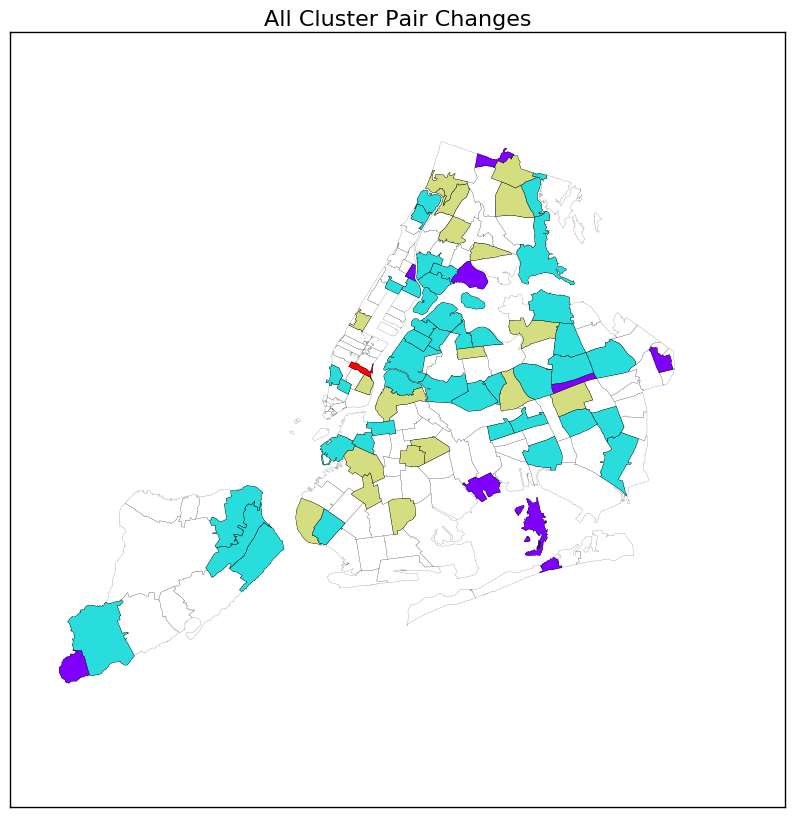

In [342]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
clusters_10year_gdf.plot(column ='Cluster_Change' , colormap = 'binary', alpha = 1, linewidth = 0.1, ax = ax)
cluster_pairs.plot(column ='Cluster_Change' , colormap = 'rainbow', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("All Cluster Pair Changes", fontsize = 16)

## The above is a plot of ALL changed zip codes; now I need to test which features changed significantly across the changed zip codes.

In [343]:
zip00_shape.head()

ZIP    Dens00_ave    age_ave  diversity_ave   income_ave  EST00  \
0  10001  88928.113635  36.675000      65.791667  1135.500000  87804   
1  10002  27673.816420  36.594444      39.883333  1383.611111  40986   
2  10003  44761.820762  34.153846      78.500000  2497.692308  47879   
3  10004  15726.797737  31.725000      70.700000   495.000000  20704   
4  10004  15726.797737  31.725000      70.700000   495.000000  20704   

           AREA  POPULATION                                           geometry  
0  1.779494e+07     22413.0  POLYGON ((981958.6472873986 213464.4530421346,...  
1  2.628013e+07     81305.0  POLYGON ((991339.8703228086 207576.7837151289,...  
2  1.553838e+07     55878.0  POLYGON ((989830.469142139 207048.1263078749, ...  
3  4.002521e+06      2187.0  POLYGON ((981197.408652395 196571.0816452205, ...  
4  1.202708e+06      2187.0  POLYGON ((972696.8446168154 193014.5477478057,...

In [344]:
features2000 = pd.merge(cluster_pairs, zip00_shape, how = 'inner', on = ['ZIP'])
features2000.head()

ZIP  Cluster2000  Cluster2010 Cluster_Change  \
0  10037            0            1              A   
1  10307            0            1              A   
2  10470            0            1              A   
3  10474            0            1              A   
4  11004            0            1              A   

                                          geometry_x   Dens00_ave    age_ave  \
0  POLYGON ((-73.93382316715753 40.81949968615795...  1665.047365  36.411111   
1  POLYGON ((-74.24966624246994 40.51555479573201...  2357.804298  33.600000   
2  POLYGON ((-73.8779026157511 40.90555223733508,...  3245.019317  34.487500   
3  POLYGON ((-73.89542858297601 40.81584469294005...  6648.035829  27.733333   
4  POLYGON ((-73.71068374074007 40.75004039450917...  2297.036146  40.900000   

   diversity_ave   income_ave  EST00          AREA  POPULATION  \
0       3.566667  1406.666667   1233  7.188981e+06     16931.0   
1      94.100000  1160.000000    194  4.602838e+07     14096.0   
2      58.850000   758.000000   2136  2.154346e+07     14740.0   
3      28.566667   806.666667   1641  4.061409e+07     12281.0   
4      57.933333  1330.166667   1134  2.260653e+07     11776.0   

                                          geometry_y  
0  POLYGON ((1002566.673984647 237849.7907543033,...  
1  POLYGON ((914830.9058869779 127205.9513468891,...  
2  POLYGON ((1018000.867525637 269218.6804442108,...  
3  POLYGON ((1013195.257386222 236528.5036987215,...  
4  POLYGON ((1064411.49189581 212668.8611293882, ...

In [345]:
len(features2000)

96

In [346]:
age2000 = features2000['age_ave'].tolist()
business2000 = features2000['Dens00_ave'].tolist()
diversity2000 = features2000['diversity_ave'].tolist()
income2000 = features2000['income_ave'].tolist()
pop2000 = features2000['POPULATION'].tolist()

In [347]:
features2010 = pd.merge(cluster_pairs, zip10_shape, how = 'inner', on = ['ZIP'])
features2010.head()

ZIP  Cluster2000  Cluster2010 Cluster_Change  \
0  10037            0            1              A   
1  10307            0            1              A   
2  10470            0            1              A   
3  10474            0            1              A   
4  11004            0            1              A   

                                          geometry_x   Dens10_ave    age_ave  \
0  POLYGON ((-73.93382316715753 40.81949968615795...  2503.647862  36.344444   
1  POLYGON ((-74.24966624246994 40.51555479573201...  3123.483013  36.000000   
2  POLYGON ((-73.8779026157511 40.90555223733508,...  3488.091925  35.500000   
3  POLYGON ((-73.89542858297601 40.81584469294005...  8057.856955  29.500000   
4  POLYGON ((-73.71068374074007 40.75004039450917...  2783.181362  43.466667   

   diversity_ave   income_ave  EST10          AREA  POPULATION  \
0      10.511111  2351.555556   1854  7.188981e+06     16931.0   
1      91.200000  1613.000000    257  4.602838e+07     14096.0   
2      51.512500   937.375000   2296  2.154346e+07     14740.0   
3      25.633333  1440.666667   1989  4.061409e+07     12281.0   
4      42.583333  1791.666667   1374  2.260653e+07     11776.0   

                                          geometry_y  
0  POLYGON ((1002566.673984647 237849.7907543033,...  
1  POLYGON ((914830.9058869779 127205.9513468891,...  
2  POLYGON ((1018000.867525637 269218.6804442108,...  
3  POLYGON ((1013195.257386222 236528.5036987215,...  
4  POLYGON ((1064411.49189581 212668.8611293882, ...

In [348]:
# Checking that dataframes same length for Pearson's test. (Already paired by zip code.) 
len(features2010)

96

In [349]:
age2010 = features2010['age_ave'].tolist()
business2010 = features2010['Dens10_ave'].tolist()
diversity2010 = features2010['diversity_ave'].tolist()
income2010 = features2010['income_ave'].tolist()
pop2010 = features2010['POPULATION'].tolist()

In [350]:
pearson_age = scipy.stats.pearsonr(age2000, age2010)
pearson_age

(0.87614272839047191, 1.5173794183690777e-31)

In [351]:
pearson_business = scipy.stats.pearsonr(business2000, business2010)
pearson_business

(0.98294593349103276, 6.1809905418380263e-71)

In [352]:
pearson_diversity = scipy.stats.pearsonr(diversity2000, diversity2010)
pearson_diversity

(0.9565071789715679, 4.3487778114508776e-52)

In [353]:
pearson_income = scipy.stats.pearsonr(income2000, income2010)
pearson_income

(0.9596493120704388, 1.3775209038779778e-53)

In [354]:
pearson_pop = scipy.stats.pearsonr(pop2000, pop2010)
pearson_pop

(1.0, 0.0)

**Pearon's Test Conclusion:**

Overall not different - but need to look at each pair type separately

In [355]:
features2000.head()

ZIP  Cluster2000  Cluster2010 Cluster_Change  \
0  10037            0            1              A   
1  10307            0            1              A   
2  10470            0            1              A   
3  10474            0            1              A   
4  11004            0            1              A   

                                          geometry_x   Dens00_ave    age_ave  \
0  POLYGON ((-73.93382316715753 40.81949968615795...  1665.047365  36.411111   
1  POLYGON ((-74.24966624246994 40.51555479573201...  2357.804298  33.600000   
2  POLYGON ((-73.8779026157511 40.90555223733508,...  3245.019317  34.487500   
3  POLYGON ((-73.89542858297601 40.81584469294005...  6648.035829  27.733333   
4  POLYGON ((-73.71068374074007 40.75004039450917...  2297.036146  40.900000   

   diversity_ave   income_ave  EST00          AREA  POPULATION  \
0       3.566667  1406.666667   1233  7.188981e+06     16931.0   
1      94.100000  1160.000000    194  4.602838e+07     14096.0   
2      58.850000   758.000000   2136  2.154346e+07     14740.0   
3      28.566667   806.666667   1641  4.061409e+07     12281.0   
4      57.933333  1330.166667   1134  2.260653e+07     11776.0   

                                          geometry_y  
0  POLYGON ((1002566.673984647 237849.7907543033,...  
1  POLYGON ((914830.9058869779 127205.9513468891,...  
2  POLYGON ((1018000.867525637 269218.6804442108,...  
3  POLYGON ((1013195.257386222 236528.5036987215,...  
4  POLYGON ((1064411.49189581 212668.8611293882, ...

In [360]:
features2000.Cluster_Change.unique()

array(['A', 'D', 'G', 'I'], dtype=object)

In [361]:
features2000_A = features2000[features2000.Cluster_Change == 'A']
features2000_D = features2000[features2000.Cluster_Change == 'D']
features2000_G = features2000[features2000.Cluster_Change == 'G']
features2000_I = features2000[features2000.Cluster_Change == 'I']

In [362]:
# Creating feature lists for Pair Type A from 2000
age2000_A = features2000_A['age_ave'].tolist()
business2000_A = features2000_A['Dens00_ave'].tolist()
diversity2000_A = features2000_A['diversity_ave'].tolist()
income2000_A = features2000_A['income_ave'].tolist()
pop2000_A = features2000_A['POPULATION'].tolist()

In [363]:
# Creating feature lists for Pair Type D from 2000
age2000_D = features2000_D['age_ave'].tolist()
business2000_D = features2000_D['Dens00_ave'].tolist()
diversity2000_D = features2000_D['diversity_ave'].tolist()
income2000_D = features2000_D['income_ave'].tolist()
pop2000_D = features2000_D['POPULATION'].tolist()

In [364]:
# Creating feature lists for Pair Type G from 2000
age2000_G = features2000_G['age_ave'].tolist()
business2000_G = features2000_G['Dens00_ave'].tolist()
diversity2000_G = features2000_G['diversity_ave'].tolist()
income2000_G = features2000_G['income_ave'].tolist()
pop2000_G = features2000_G['POPULATION'].tolist()

In [365]:
# Creating feature lists for Pair Type I from 2000
age2000_I = features2000_I['age_ave'].tolist()
business2000_I = features2000_I['Dens00_ave'].tolist()
diversity2000_I = features2000_I['diversity_ave'].tolist()
income2000_I = features2000_I['income_ave'].tolist()
pop2000_I = features2000_I['POPULATION'].tolist()

In [366]:
features2010_A = features2010[features2010.Cluster_Change == 'A']
features2010_D = features2010[features2010.Cluster_Change == 'D']
features2010_G = features2010[features2010.Cluster_Change == 'G']
features2010_I = features2010[features2010.Cluster_Change == 'I']

In [367]:
# Creating feature lists for Pair Type A from 2010
age2010_A = features2010_A['age_ave'].tolist()
business2010_A = features2010_A['Dens10_ave'].tolist()
diversity2010_A = features2010_A['diversity_ave'].tolist()
income2010_A = features2010_A['income_ave'].tolist()
pop2010_A = features2010_A['POPULATION'].tolist()

In [368]:
# Creating feature lists for Pair Type D from 2010
age2010_D = features2010_D['age_ave'].tolist()
business2010_D = features2010_D['Dens10_ave'].tolist()
diversity2010_D = features2010_D['diversity_ave'].tolist()
income2010_D = features2010_D['income_ave'].tolist()
pop2010_D = features2010_D['POPULATION'].tolist()

In [369]:
# Creating feature lists for Pair Type G from 2010
age2010_G = features2010_G['age_ave'].tolist()
business2010_G = features2010_G['Dens10_ave'].tolist()
diversity2010_G = features2010_G['diversity_ave'].tolist()
income2010_G = features2010_G['income_ave'].tolist()
pop2010_G = features2010_G['POPULATION'].tolist()

In [370]:
# Creating feature lists for Pair Type I from 2010
age2010_I = features2010_I['age_ave'].tolist()
business2010_I = features2010_I['Dens10_ave'].tolist()
diversity2010_I = features2010_I['diversity_ave'].tolist()
income2010_I = features2010_I['income_ave'].tolist()
pop2010_I = features2010_I['POPULATION'].tolist()

In [371]:
pearson_age_A = scipy.stats.pearsonr(age2000_A, age2010_A)
pearson_age_A

(0.97339343419802671, 6.4336779851428466e-15)

In [373]:
len(age2000_A)

23

In [374]:
pearson_age_D = scipy.stats.pearsonr(age2000_D, age2010_D)
pearson_age_D

(0.80256864206074552, 2.4059555015792762e-12)

In [ ]:
plt.hist(age2000_B, range = [25, 48])

In [ ]:
plt.hist(age2010_B, range = [25, 48])

In [375]:
pearson_age_G = scipy.stats.pearsonr(age2000_G, age2010_G)
pearson_age_G

(0.96418855680394511, 5.4001327185234069e-13)

In [377]:
len(age2000_G)

22

In [378]:
pearson_age_I = scipy.stats.pearsonr(age2000_I, age2010_I)
pearson_age_I

(nan, nan)

In [379]:
len(age2000_I)

1

In [380]:
# NOt enough values in age2000 group I to do analysis

In [ ]:
plt.hist(age2000_F, range = [25, 48])

In [ ]:
plt.hist(age2010_F, range = [25, 48])

### Pair Groups I doesn't have enough data to compare (thus, the nan results) so I will continue doing Pearon's on Groups A, D, and G only.

In [381]:
pearson_business_A = scipy.stats.pearsonr(business2000_A, business2010_A)
pearson_business_A

(0.99426041894190376, 7.1432412636749473e-22)

In [ ]:
plt.hist(business2000_B, range = [0, 30000])

In [ ]:
plt.hist(business2010_B, range = [0, 30000])

In [382]:
pearson_business_D = scipy.stats.pearsonr(business2000_D, business2010_D)
pearson_business_D

(0.99111685719654319, 1.0155421701897973e-43)

In [ ]:
plt.hist(business2000_F, range = [0, 30000])

In [383]:
pearson_business_G = scipy.stats.pearsonr(business2000_G, business2010_G)
pearson_business_G

(0.96153401997459342, 1.0918491978679258e-12)

In [ ]:
plt.hist(business2010_F)

In [384]:
pearson_income_A = scipy.stats.pearsonr(income2000_A, income2010_A)
pearson_income_A

(0.94047744367517849, 2.6126172706761341e-11)

In [ ]:
plt.hist(income2000_B, range=[0, 6500])

In [ ]:
plt.hist(income2010_B, range=[0, 6500])

In [ ]:
pearson_income_D = scipy.stats.pearsonr(income2000_D, income2010_D)
pearson_income_D

In [ ]:
plt.hist(income2000_D, range=[0, 4500])

In [ ]:
plt.hist(income2010_D)

In [385]:
pearson_income_G = scipy.stats.pearsonr(income2000_G, income2010_G)
pearson_income_G

(0.97774904960856468, 4.8985129911418307e-15)

In [386]:
pearson_pop_A = scipy.stats.pearsonr(pop2000_A, pop2010_A)
pearson_pop_A

(1.0, 0.0)

In [ ]:
plt.hist(pop2000_B) 

In [ ]:
plt.hist(pop2010_B) 

In [387]:
pearson_pop_D = scipy.stats.pearsonr(pop2000_D, pop2010_D)
pearson_pop_D

(1.0, 0.0)

In [ ]:
plt.hist(pop2000_F)

In [ ]:
plt.hist(pop2010_F)

In [388]:
pearson_pop_G = scipy.stats.pearsonr(pop2000_G, pop2010_G)
pearson_pop_G

(1.0, 0.0)

In [ ]:
## All of the above showing strong, positive correlations.
## Just plotted histograms for the sake of completeness - none are significantly different.
## How could this be? Probably the smaller clusters (with just 1 pair each) affected the cluster groupings. 
## Probably a better method to avoid such small sized clusters. 

## Step 13:
### Comment on the strength and weaknesses of this analysis, and on your findings (this is not the last step, but comments should be given throughout the notebook, and summarized here).